# 01 - Reconstruction

Reconstruct speed, acceleration, direction, and other derived signals from position data.

In [20]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [21]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nfl_big_data_bowl_2026_analytics = kagglehub.competition_download('nfl-big-data-bowl-2026-analytics')

print('Data source import complete.')

Data source import complete.


In [22]:
print(nfl_big_data_bowl_2026_analytics)

/root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics


In [23]:
!ls /root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics

114239_nfl_competition_files_published_analytics_final


In [24]:
!ls /root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final

supplementary_data.csv	train


In [25]:
import pandas as pd
import os

# Define the path to the data directory
data_dir = '/root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final'

# Construct the full path to the output data for week 1
week1_output_path = os.path.join(data_dir, 'train', 'output_2023_w01.csv')

# Load the week 1 output data into a pandas DataFrame
week1_output_df = pd.read_csv(week1_output_path)

# Display the first few rows of the DataFrame
print("First 5 rows of output_2023_w01.csv:")
display(week1_output_df.head())

First 5 rows of output_2023_w01.csv:


,game_id,play_id,nfl_id,frame_id,x,y
0,2023090700,101,46137,1,56.22,17.28
1,2023090700,101,46137,2,56.63,16.88
2,2023090700,101,46137,3,57.06,16.46
3,2023090700,101,46137,4,57.48,16.02
4,2023090700,101,46137,5,57.91,15.56


In [26]:
import pandas as pd
import os

# Define the path to the data directory
data_dir = '/root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final/train'

# Construct the full path to the input data for week 1
week1_input_path = os.path.join(data_dir, 'input_2023_w01.csv')

# Load the week 1 input data into a pandas DataFrame
week1_input_df = pd.read_csv(week1_input_path)

# Display the first few rows of the DataFrame
display(week1_input_df.sample(20))

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
130148,2023091006,1828,False,43306,6,right,38,Keanu Neal,6-1,216,...,Defensive Coverage,42.22,33.45,0.12,0.11,261.78,265.60,11,43.730000,9.460000
87972,2023091004,413,False,52453,22,left,55,Antoine Winfield Jr.,5-9,205,...,Defensive Coverage,48.11,15.42,6.90,0.43,159.02,123.28,7,49.980000,26.980000
233816,2023091011,3491,False,43351,24,right,72,James Bradberry,6-1,212,...,Defensive Coverage,81.04,39.68,6.78,2.35,98.56,121.78,26,100.139999,2.660000
269054,2023091013,3686,False,55166,24,right,41,Juanyeh Thomas,6-3,217,...,Defensive Coverage,66.46,28.62,5.23,2.79,34.62,272.57,11,42.779999,45.860001
32265,2023091000,3078,False,54523,29,right,46,Troy Andersen,6-3,230,...,Defensive Coverage,49.63,35.03,5.14,2.59,0.68,339.22,27,87.059998,3.030000
215333,2023091010,4426,False,42388,16,right,35,Eric Kendricks,6-0,232,...,Defensive Coverage,35.00,19.27,4.54,4.41,159.04,226.72,26,78.260002,8.420000
251411,2023091012,2656,True,54618,6,right,56,Riq Woolen,6-4,205,...,Defensive Coverage,61.31,40.50,1.85,0.74,82.01,301.97,16,74.370003,45.520000
190155,2023091009,2634,False,43370,2,right,85,Austin Hooper,6-4,254,...,Other Route Runner,83.99,18.91,0.01,0.20,70.99,49.66,9,83.339996,7.070000
159672,2023091007,4234,True,39983,2,right,41,Zach Ertz,6-5,250,...,Targeted Receiver,39.22,21.01,0.36,2.08,67.26,85.67,10,42.549999,9.770000
19825,2023090700,3674,False,54562,6,left,85,Kerby Joseph,6-1,200,...,Defensive Coverage,70.91,23.95,0.78,0.85,201.73,122.55,9,80.410004,9.140000


In [27]:
import pandas as pd
import os

# Define the path to the data directory
data_dir = '/root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final'

# Construct the full path to the supplementary data
supplementary_data_path = os.path.join(data_dir, 'supplementary_data.csv')

# Load the supplementary data into a pandas DataFrame
supplementary_df = pd.read_csv(supplementary_data_path)

# Display the first few rows of the DataFrame
print("First 5 rows of supplementary_data.csv:")
display(supplementary_df.head())

First 5 rows of supplementary_data.csv:


/tmp/ipython-input-3401357624.py:11: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supplementary_df = pd.read_csv(supplementary_data_path)


,game_id,season,week,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,play_id,play_description,quarter,...,team_coverage_type,penalty_yards,pre_penalty_yards_gained,yards_gained,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added
0,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,3461,(10:46) (Shotgun) J.Goff pass deep left to J.R...,4,...,COVER_2_ZONE,NaN,18,18,-0.664416,2.945847,0.834296,0.165704,-0.081149,0.081149
1,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,461,(7:30) J.Goff pass short right to J.Reynolds t...,1,...,COVER_6_ZONE,NaN,21,21,1.926131,1.345633,0.544618,0.455382,-0.029415,0.029415
2,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1940,(:09) (Shotgun) J.Goff pass incomplete deep ri...,2,...,COVER_2_ZONE,NaN,0,0,0.281891,-0.081964,0.771994,0.228006,0.000791,-0.000791
3,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1711,"(:45) (No Huddle, Shotgun) P.Mahomes pass deep...",2,...,COVER_2_ZONE,NaN,26,26,3.452352,2.342947,0.663187,0.336813,0.041843,-0.041843
4,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1588,(1:54) (Shotgun) P.Mahomes pass incomplete dee...,2,...,COVER_4_ZONE,NaN,0,0,1.921525,-0.324035,0.615035,0.384965,0.000061,-0.000061


In [28]:
# Step 0 — Setup & constants

import pandas as pd, numpy as np, json, hashlib
from pathlib import Path
FRAME_RATE = 10
DT = 1.0 / FRAME_RATE
RANDOM_STATE = 100
OUTDIR = Path('data/interim')
OUTDIR.mkdir(parents=True, exist_ok=True)
SAMPLES_DIR = Path('data/samples')
SAMPLES_DIR.mkdir(parents=True, exist_ok=True)
LOG_PATH = OUTDIR / 'merge_log.txt'

# Validation: OUTDIR and SAMPLES_DIR exist.
print(f"OUTDIR exists: {OUTDIR.exists()}")
print(f"SAMPLES_DIR exists: {SAMPLES_DIR.exists()}")

OUTDIR exists: True
SAMPLES_DIR exists: True


In [29]:
# Step 1 — Load & dtype normalization

# Assuming the data files are located in the paths identified earlier
data_dir = '/root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final/train'
supplementary_data_path = '/root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final/supplementary_data.csv'

# Action:
# Use the correct file paths and read functions based on previous successful loads
# (assuming input and output are csv based on previous successful loads, not parquet as in playbook)
input_df = pd.read_csv(os.path.join(data_dir, 'input_2023_w01.csv'))
output_df = pd.read_csv(os.path.join(data_dir, 'output_2023_w01.csv'))
# Added low_memory=False based on the DtypeWarning encountered in cell zkOc9hdPmU--
supp_df = pd.read_csv(supplementary_data_path, low_memory=False)


# Normalize join keys to ints
for df in (input_df, output_df, supp_df):
    for c in ['game_id','play_id']:
        if c in df.columns:
            df[c] = df[c].astype('int64')
if 'nfl_id' in input_df.columns:
    input_df['nfl_id'] = input_df['nfl_id'].astype('int64')
if 'nfl_id' in output_df.columns:
    output_df['nfl_id'] = output_df['nfl_id'].astype('int64')

# Validation:
# Print shapes and dtypes:
print(input_df.shape, output_df.shape, supp_df.shape)
print(input_df.dtypes[['game_id','play_id','nfl_id']])
print(output_df.dtypes[['game_id','play_id','nfl_id']])
print(supp_df.dtypes[['game_id','play_id']]) # Added supp_df dtypes check for join keys

(285714, 23) (32088, 6) (18009, 41)
game_id    int64
play_id    int64
nfl_id     int64
dtype: object
game_id    int64
play_id    int64
nfl_id     int64
dtype: object
game_id    int64
play_id    int64
dtype: object


In [30]:
# Step 2 — Rename frame columns to avoid shadowing

input_df = input_df.rename(columns={'frame_id':'pre_frame_id'})
output_df = output_df.rename(columns={'frame_id':'post_frame_id'})

# Validation: `pre_frame_id` present in `input_df`, `post_frame_id` in `output_df`.
print("`pre_frame_id` present in `input_df`:", 'pre_frame_id' in input_df.columns)
print("`post_frame_id` present in `output_df`:", 'post_frame_id' in output_df.columns)

`pre_frame_id` present in `input_df`: True
`post_frame_id` present in `output_df`: True


In [31]:
# Step 3 — Basic uniqueness & sanity checks

# Action: (There is no specific "Action" code provided in the playbook for this step,
# only the validation checks which serve as the action in this case)

# Validation: catch obvious duplicates or invalid ranges early.
print("input dupes:", input_df.duplicated(['game_id','play_id','nfl_id','pre_frame_id']).sum())
print("output dupes:", output_df.duplicated(['game_id','play_id','nfl_id','post_frame_id']).sum())
print("supp dupes:", supp_df.duplicated(['game_id','play_id']).sum())

# ensure min frame ids >= 1 if present
assert input_df['pre_frame_id'].min() >= 1
assert output_df['post_frame_id'].min() >= 1

input dupes: 0
output dupes: 0
supp dupes: 0


In [32]:
# Step 5 — Compute true pre-throw frame counts (n_pre_frames) (critical fix)

# Purpose: count actual number of input frames per player (don’t rely on pre_frame_id labels).

# Why: some input pre_frame_id columns can be improperly labeled (many 1s). Counting rows is robust.

# Action:
pre_counts = (
    input_df.groupby(['game_id','play_id','nfl_id'])
    .size()
    .reset_index(name='n_pre_frames')
)
# keep pre_counts for mapping into output


# Validation:
print("pre_counts sample:", pre_counts.head())
# optional: stats
print(pre_counts['n_pre_frames'].describe())

pre_counts sample:       game_id  play_id  nfl_id  n_pre_frames
0  2023090700      101   43290            26
1  2023090700      101   44930            26
2  2023090700      101   46137            26
3  2023090700      101   52546            26
4  2023090700      101   53487            26
count    10089.000000
mean        28.319358
std          8.890308
min          9.000000
25%         22.000000
50%         27.000000
75%         33.000000
max         74.000000
Name: n_pre_frames, dtype: float64


In [33]:
# Step 4 — Extract static player attributes

# Purpose: single canonical player-per-play attributes to broadcast to frames.

# Action:
player_attrs = input_df[[
 'game_id','play_id','nfl_id','player_to_predict','player_name','player_height',
 'player_weight','player_birth_date','player_position','player_side','player_role',
 'num_frames_output','ball_land_x','ball_land_y'
]].drop_duplicates(subset=['game_id','play_id','nfl_id'])

assert not player_attrs.duplicated(['game_id','play_id','nfl_id']).any()

# Validation: one row per (game_id, play_id, nfl_id) in player_attrs.
print("player_attrs shape:", player_attrs.shape)
print("player_attrs head:", player_attrs.head())

player_attrs shape: (10089, 14)
player_attrs head:         game_id  play_id  nfl_id  player_to_predict     player_name  \
0    2023090700      101   54527              False      Bryan Cook   
26   2023090700      101   46137               True     Justin Reid   
52   2023090700      101   52546               True  L'Jarius Sneed   
78   2023090700      101   53487              False     Nick Bolton   
104  2023090700      101   54486              False  Trent McDuffie   

    player_height  player_weight player_birth_date player_position  \
0             6-1            210        1999-09-07              FS   
26            6-1            204        1997-02-15              SS   
52            6-1            193        1997-01-21              CB   
78            6-0            232        2000-03-10             MLB   
104          5-11            195        2000-09-13              CB   

    player_side         player_role  num_frames_output  ball_land_x  \
0       Defense  Defensive Cov

In [34]:
# Step 6 — Validate num_frames_output vs observed output frames (early sanity)

# Purpose: detect gross mismatches before continuing.

# Action:
obs_out = (
    output_df.groupby(['game_id','play_id','nfl_id'])['post_frame_id']
    .nunique().reset_index(name='observed_output_frames')
)
cmp = player_attrs[['game_id','play_id','nfl_id','num_frames_output']].merge(obs_out, on=['game_id','play_id','nfl_id'], how='left')
cmp['observed_output_frames'] = cmp['observed_output_frames'].fillna(0).astype(int)
cmp['match'] = cmp['observed_output_frames'] == cmp['num_frames_output']
print("initial num_frames_output mismatches:", (~cmp['match']).sum())

# Validation: log cmp[~cmp['match']].sample(5) to inspect typical cases.
print(cmp[~cmp['match']].sample(min(5, (~cmp['match']).sum()))) # Ensure we don't sample more than available mismatches

initial num_frames_output mismatches: 7410
         game_id  play_id  nfl_id  num_frames_output  observed_output_frames  \
4295  2023091005     4124   39973                 13                       0   
1367  2023091001     1797   53456                 15                       0   
7884  2023091011     1964   53579                 11                       0   
7813  2023091011     1661   53444                  8                       0   
9607  2023091100      559   54469                  9                       0   

      match  
4295  False  
1367  False  
7884  False  
7813  False  
9607  False  


In [35]:
# ✅ FINAL CLEAN VERSION OF STEP 7
reconstructed_rows = []
play_keys = sorted(set(input_df[['game_id','play_id']].itertuples(index=False, name=None)))

for game_id, play_id in play_keys:
    in_play = input_df.query("game_id == @game_id and play_id == @play_id").copy()
    out_play = output_df.query("game_id == @game_id and play_id == @play_id").copy()

    if out_play.empty and in_play.empty:
        continue

    # Label phases
    in_play['phase'] = 'pre_throw'
    out_play['phase'] = 'post_throw'

    # Map pre-frame counts per player
    pre_map = pre_counts.query("game_id == @game_id and play_id == @play_id") \
                        .set_index('nfl_id')['n_pre_frames'].to_dict()

    out_play['n_pre_frames'] = out_play['nfl_id'].map(pre_map).fillna(0).astype(int)
    out_play['frame_id'] = out_play['post_frame_id'] + out_play['n_pre_frames']

    # Only add missing players if they don't appear AT ALL in output
    missing_players = set(in_play['nfl_id']) - set(out_play['nfl_id'])
    missing_rows = in_play[in_play['nfl_id'].isin(missing_players)].copy()

    # Merge static attributes
    attrs_play = player_attrs.query("game_id == @game_id and play_id == @play_id")
    out_play = out_play.merge(attrs_play, on=['game_id','play_id','nfl_id'], how='left', validate='m:1')
    in_play = in_play.rename(columns={'pre_frame_id': 'frame_id'})

    # Combine safely — note that we only concat missing pre rows once
    combined = pd.concat([in_play, out_play, missing_rows], ignore_index=True, sort=False)

    # Sort and deduplicate just in case
    combined = combined.sort_values(['game_id','play_id','nfl_id','frame_id']).drop_duplicates(
        subset=['game_id','play_id','nfl_id','frame_id']
    ).reset_index(drop=True)

    reconstructed_rows.append(combined)

print(f"✅ Processed {len(reconstructed_rows)} plays successfully.")


✅ Processed 819 plays successfully.


In [36]:
# 🧭 Step 8 — Combine All Plays, Finalize, and Validate
# ----------------------------------------------------
# 🎯 Purpose:
# Merge all per-play reconstructions from Step 7 into one full dataset,
# ensure column consistency, continuous frame timelines, and no duplication.

# 🧩 Action:

import pandas as pd

# Combine every reconstructed play into one unified dataset
merged_df = pd.concat(reconstructed_rows, ignore_index=True, sort=False)

# Drop any redundant debug columns if present
drop_cols = [c for c in merged_df.columns if c in ['pre_frame_id','post_frame_id','n_pre_frames']]
merged_df = merged_df.drop(columns=drop_cols, errors='ignore')

# Sort to ensure chronological order within every player's play timeline
merged_df = merged_df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id']).reset_index(drop=True)

# Standardize column order for readability (optional)
col_order = ['game_id','play_id','nfl_id','frame_id','phase',
             'x','y','player_name','player_position','player_side','player_role',
             'player_height','player_weight','ball_land_x','ball_land_y',
             'num_frames_output','note']
merged_df = merged_df[[c for c in col_order if c in merged_df.columns] +
                      [c for c in merged_df.columns if c not in col_order]]

# 🧠 Validation Section ---------------------------------------

# 1️⃣ Check duplicates — each player-frame pair should be unique
dup_count = merged_df.duplicated(['game_id','play_id','nfl_id','frame_id']).sum()
assert dup_count == 0, f"❌ Found {dup_count} duplicate player-frame rows!"

# 2️⃣ Frame continuity — frames must progress smoothly per player
gaps = (merged_df
        .groupby(['game_id','play_id','nfl_id'])['frame_id']
        .apply(lambda x: (x.diff().dropna() != 1).sum())
        .sum())
print(f"🔹 Total non-contiguous frame steps across players: {gaps}")

# 3️⃣ Sanity check: every player should have both pre & post phases when applicable
phase_check = (merged_df.groupby(['game_id','play_id','nfl_id'])['phase']
               .nunique()
               .value_counts()
               .to_dict())
print(f"🔹 Phase presence per player: {phase_check} (1=only pre or post, 2=both)")

# 4️⃣ Log sample structure
print("✅ Combined dataset shape:", merged_df.shape)
print("✅ Unique plays:", merged_df[['game_id','play_id']].drop_duplicates().shape[0])
print("✅ Unique players:", merged_df['nfl_id'].nunique())

# 5️⃣ Optional: Sample 2–3 random players and display their frame continuity
sample_players = merged_df['nfl_id'].drop_duplicates().sample(min(3, merged_df['nfl_id'].nunique()), random_state=42)
for pid in sample_players:
    temp = merged_df[merged_df['nfl_id'] == pid].head(5)
    print(f"\n👀 Player {pid} sample frames:\n", temp[['game_id','play_id','frame_id','phase']].head())

# -------------------------------------------------------------

print("\n✅ Step 8 completed — all plays combined and validated for frame integrity.")


🔹 Total non-contiguous frame steps across players: 0
🔹 Phase presence per player: {1: 7410, 2: 2679} (1=only pre or post, 2=both)
✅ Combined dataset shape: (325212, 24)
✅ Unique plays: 819
✅ Unique players: 737

👀 Player 54611 sample frames:
            game_id  play_id  frame_id      phase
292561  2023091013      485       1.0  pre_throw
292562  2023091013      485       2.0  pre_throw
292563  2023091013      485       3.0  pre_throw
292564  2023091013      485       4.0  pre_throw
292565  2023091013      485       5.0  pre_throw

👀 Player 55876 sample frames:
          game_id  play_id  frame_id      phase
2187  2023090700      461       1.0  pre_throw
2188  2023090700      461       2.0  pre_throw
2189  2023090700      461       3.0  pre_throw
2190  2023090700      461       4.0  pre_throw
2191  2023090700      461       5.0  pre_throw

👀 Player 54679 sample frames:
            game_id  play_id  frame_id      phase
232337  2023091010     1940       1.0  pre_throw
232338  2023091010 

In [38]:
# Step 9 — Standardize play direction (flip coordinates if needed)

# Purpose: ensure all plays oriented in same direction (easier metrics).

# Action:
# get play direction map (one per play)
if 'play_direction' in input_df.columns:
    dir_map = input_df[['game_id','play_id','play_direction']].drop_duplicates()
    merged_df = merged_df.merge(dir_map, on=['game_id','play_id'], how='left', validate='m:1')

    # Now that play_direction is merged, create the mask and flip coordinates
    mask = merged_df['play_direction'] == 'left'
    merged_df.loc[mask, 'x'] = 120 - merged_df.loc[mask, 'x']
    # flip ball landing x too
    merged_df.loc[mask, 'ball_land_x'] = 120 - merged_df.loc[mask, 'ball_land_x']

# Validation: sample plays with play_direction=='left' and visually confirm flip.
# This validation requires visual inspection, which I cannot perform directly.
# I will print a sample of rows where play_direction is 'left' for manual inspection.
print("Sample of rows with play_direction 'left' for visual validation:")
# Ensure there are rows with play_direction 'left' before sampling
if 'play_direction' in merged_df.columns and not merged_df[merged_df['play_direction'] == 'left'].empty:
    display(merged_df[merged_df['play_direction'] == 'left'].sample(min(5, merged_df[merged_df['play_direction'] == 'left'].shape[0])))
elif 'play_direction' not in merged_df.columns:
    print("play_direction column not found in merged_df after merge.")
else:
    print("No rows with play_direction 'left' to sample.")

Sample of rows with play_direction 'left' for visual validation:


,game_id,play_id,nfl_id,frame_id,phase,x,y,player_name,player_position,player_side,...,player_to_predict,play_direction_x,absolute_yardline_number,player_birth_date,s,a,dir,o,play_direction_y,play_direction
266629,2023091011,3772,46212,34.0,pre_throw,34.17,20.06,Ja'Whaun Bentley,ILB,Defense,...,True,left,93.0,1996-08-24,0.72,1.52,246.70,69.98,left,left
135675,2023091005,3603,46168,15.0,pre_throw,84.69,17.13,Isaac Yiadom,CB,Defense,...,False,left,37.0,1996-02-20,3.88,4.34,330.37,25.91,left,left
142306,2023091006,575,46080,15.0,pre_throw,92.09,20.49,Minkah Fitzpatrick,FS,Defense,...,True,left,40.0,1996-11-17,2.91,0.86,254.94,108.64,left,left
173328,2023091007,2135,52474,8.0,pre_throw,24.09,32.89,Antonio Gibson,RB,Offense,...,False,left,91.0,1998-06-23,1.93,3.16,10.81,294.64,left,left
304477,2023091013,3257,47872,3.0,pre_throw,106.44,26.69,Bobby Okereke,ILB,Defense,...,False,left,17.0,1996-07-29,0.32,0.21,123.62,149.35,left,left


In [39]:
# Step 10 — Merge supplementary play-level context (use validate)

# Purpose: attach pass_result, expected_points_added, etc., safely.

# Action:
final_df = pd.merge(merged_df, supp_df, on=['game_id','play_id'], how='left', validate='m:1')

# Validation:
# If validate raises, inspect duplicates in supp_df.
# Check final_df['pass_result'].isna().sum() — log plays missing supplementary.
print("frames missing pass_result:", final_df['pass_result'].isna().sum())

frames missing pass_result: 0


In [40]:
# Step 11 — Handle missing player attributes / output-only players

# Purpose: decide policy for players appearing in output but not in input.

# Action (choose policy A or B):

final_df['missing_attrs'] = final_df['player_name'].isna()
print("rows with missing attrs:", final_df['missing_attrs'].sum())

# Option A: keep & flag
final_df['player_name'] = final_df['player_name'].fillna('UNKNOWN')
print("Policy A: Kept rows with missing attributes and filled player_name with 'UNKNOWN'.")

# Option B: drop rows (if chosen)
# final_df = final_df[~final_df['missing_attrs']]
# print("Policy B: Dropped rows with missing attributes.")


# Validation: fraction of missing attrs should be tiny; if large, investigate causes.
# The print statement above serves as the primary validation for this step.

rows with missing attrs: 0
Policy A: Kept rows with missing attributes and filled player_name with 'UNKNOWN'.


In [41]:
# Step 13 — Quality evaluations & final checks (must run)

# Purpose: ensure no leaks, mismatches, or unexpected changes before saving.

# Action & checks:

# 1) duplicates
assert not final_df.duplicated(['game_id','play_id','nfl_id','frame_id']).any()
print("1) Duplicates check passed: No duplicate player-frame rows.")


# 2) continuity gaps summary
gap_counts = final_df.groupby(['game_id','play_id','nfl_id'])['frame_id'].apply(lambda x: (x.diff().dropna() != 1).sum())
print("2) players with gaps:", (gap_counts>0).sum())

# 3) observed output frames vs expected (final authoritative check)
obs_counts = output_df.groupby(['game_id','play_id','nfl_id'])['post_frame_id'].nunique().reset_index(name='observed_output_frames')
cmp_final = player_attrs[['game_id','play_id','nfl_id','num_frames_output']].merge(obs_counts, on=['game_id','play_id','nfl_id'], how='left')
cmp_final['observed_output_frames'] = cmp_final['observed_output_frames'].fillna(0).astype(int)
cmp_final['match'] = cmp_final['observed_output_frames'] == cmp_final['num_frames_output']
mismatch_count = (~cmp_final['match']).sum()
print("3) final num_frames_output mismatch count:", mismatch_count)

# 4) missing context frames
print("4) frames missing pass_result:", final_df['pass_result'].isna().sum())


# Validation:
# mismatch_count should be small (ideally 0). If >0, sample mismatches:
if mismatch_count > 0:
    print("\nSample of final num_frames_output mismatches:")
    display(cmp_final[~cmp_final['match']].head(10))
else:
    print("\nNo final num_frames_output mismatches found.")

# players with gaps ideally 0.
if (gap_counts > 0).sum() > 0:
    print("\nSample of players with continuity gaps:")
    display(gap_counts[gap_counts > 0].head(10))
else:
    print("\nNo continuity gaps found.")

1) Duplicates check passed: No duplicate player-frame rows.
2) players with gaps: 0
3) final num_frames_output mismatch count: 7410
4) frames missing pass_result: 0

Sample of final num_frames_output mismatches:


,game_id,play_id,nfl_id,num_frames_output,observed_output_frames,match
0,2023090700,101,54527,21,0,False
3,2023090700,101,53487,21,0,False
4,2023090700,101,54486,21,0,False
5,2023090700,101,53541,21,0,False
6,2023090700,101,53959,21,0,False
7,2023090700,101,43290,21,0,False
11,2023090700,194,47888,9,0,False
12,2023090700,194,44906,9,0,False
14,2023090700,194,54562,9,0,False
16,2023090700,194,46213,9,0,False



No continuity gaps found.


In [42]:
# Step 14 — Save safely with metadata & checksum

# Purpose: persist reproducible artifact and log metadata.

# Action:
out_file = OUTDIR / 'reconstructed_week01.parquet'
final_df.to_parquet(out_file, index=False, compression='snappy')

# md5 checksum
with open(out_file, 'rb') as f:
    data = f.read()
    md5 = hashlib.md5(data).hexdigest()

meta = {
  'rows': len(final_df),
  'cols': list(final_df.columns),
  'md5': md5,
  'frame_rate': FRAME_RATE,
  'date': pd.Timestamp.now().isoformat(),
  'mismatch_count': int(mismatch_count)
}
with open(OUTDIR / 'reconstruct_week01_meta.json', 'w') as f:
    json.dump(meta, f, indent=2)

# quick load back verification
df_check = pd.read_parquet(out_file)
assert len(df_check) == meta['rows']

# Validation: load-check succeeded; the md5 written.
print(f"File saved successfully to {out_file}")
print(f"MD5 checksum: {md5}")
print(f"Metadata saved to {OUTDIR / 'reconstruct_week01_meta.json'}")
print("Load-back verification successful.")

File saved successfully to data/interim/reconstructed_week01.parquet
MD5 checksum: 214be720ffc09af9fe525ec51c36fe77
Metadata saved to data/interim/reconstruct_week01_meta.json
Load-back verification successful.


In [43]:
# Step 15 — Save small visual sample & text log for hand-check

# Purpose: produce review artifacts for quick manual inspection and CI.

# Action:
# Save 3 sample plays of interest (deep/short/contested)
sample_plays = final_df.groupby(['game_id','play_id']).size().reset_index().sample(3, random_state=RANDOM_STATE)[['game_id','play_id']]
for _, row in sample_plays.iterrows():
    g, p = row['game_id'], row['play_id']
    final_df[(final_df['game_id']==g) & (final_df['play_id']==p)].to_parquet(SAMPLES_DIR / f'play_{g}_{p}.parquet', index=False)

# Write a plain merge log
with open(LOG_PATH, 'w') as f:
    f.write(f"merged rows: {len(final_df)}\n")
    f.write(f"mismatch_count: {mismatch_count}\n")
    f.write("Top mismatches (examples):\n")
    # Check if cmp_final exists and has mismatches before trying to write to log
    if 'cmp_final' in locals() and not cmp_final[~cmp_final['match']].empty:
        f.write(cmp_final[~cmp_final['match']].head(20).to_csv(index=False))
    else:
        f.write("No mismatches found or cmp_final not available.\n")


# Validation: sample files exist, merge_log.txt contains counts and mismatch examples.
print(f"Sample play files saved to {SAMPLES_DIR}")
print(f"Merge log saved to {LOG_PATH}")

Sample play files saved to data/samples
Merge log saved to data/interim/merge_log.txt


Visualizing tracks for sample play Game ID: 2023091011, Play ID: 2093


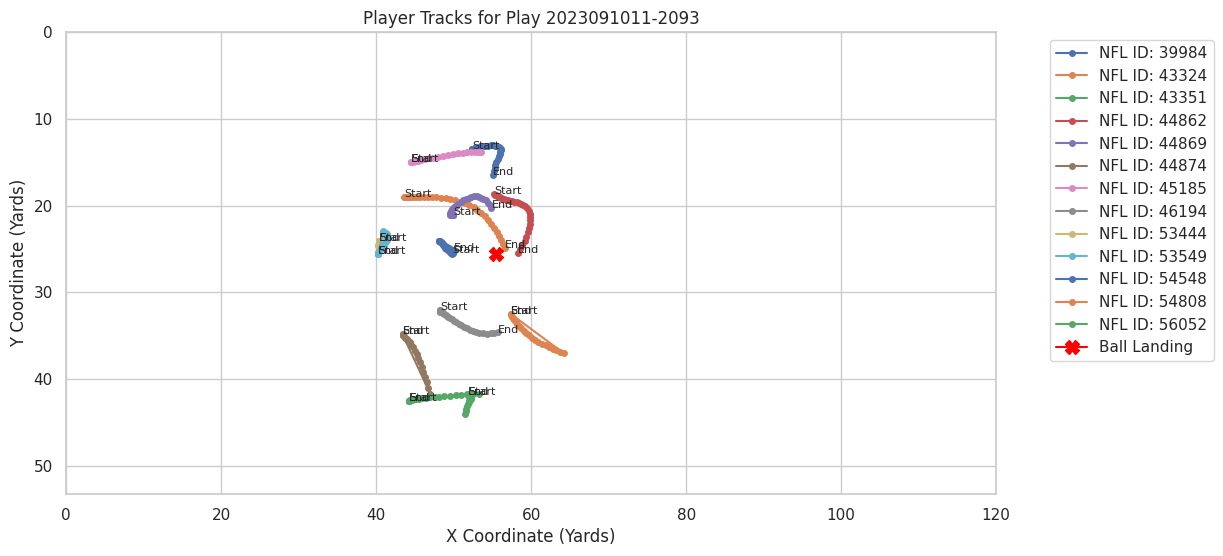

In [44]:
# Visualize player tracks for a sample play

import matplotlib.pyplot as plt
import seaborn as sns

# Select a sample play from the saved samples or randomly from the final_df
# Using the sample plays saved in Step 15 if they exist, otherwise pick one randomly
sample_play_files = list(SAMPLES_DIR.glob('play_*.parquet'))

if sample_play_files:
    # Load one of the sample plays
    sample_play_path = sample_play_files[0] # Just pick the first one
    sample_play_df = pd.read_parquet(sample_play_path)
    game_id, play_id = sample_play_df[['game_id', 'play_id']].iloc[0].values
    print(f"Visualizing tracks for sample play Game ID: {game_id}, Play ID: {play_id}")
else:
    # If no sample files, pick a random play from the final_df
    print("No sample play files found. Picking a random play from the final_df.")
    random_play_key = final_df.sample(1, random_state=RANDOM_STATE)[['game_id', 'play_id']].iloc[0]
    game_id, play_id = random_play_key.values
    sample_play_df = final_df[(final_df['game_id'] == game_id) & (final_df['play_id'] == play_id)].copy()
    print(f"Visualizing tracks for random play Game ID: {game_id}, Play ID: {play_id}")


# Get unique NFL IDs in the sample play
player_ids = sample_play_df['nfl_id'].unique()

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Plot tracks for each player
for nfl_id in player_ids:
    player_df = sample_play_df[sample_play_df['nfl_id'] == nfl_id].sort_values('frame_id')
    plt.plot(player_df['x'], player_df['y'], marker='o', linestyle='-', markersize=4, label=f'NFL ID: {nfl_id}')
    # Optional: Mark start and end points
    plt.text(player_df['x'].iloc[0], player_df['y'].iloc[0], 'Start', fontsize=8)
    plt.text(player_df['x'].iloc[-1], player_df['y'].iloc[-1], 'End', fontsize=8)


# Add ball landing location if available
if 'ball_land_x' in sample_play_df.columns and 'ball_land_y' in sample_play_df.columns:
    ball_land_x = sample_play_df['ball_land_x'].iloc[0]
    ball_land_y = sample_play_df['ball_land_y'].iloc[0]
    plt.plot(ball_land_x, ball_land_y, marker='X', markersize=10, color='red', label='Ball Landing')


plt.title(f'Player Tracks for Play {game_id}-{play_id}')
plt.xlabel('X Coordinate (Yards)')
plt.ylabel('Y Coordinate (Yards)')
plt.xlim(0, 120)
plt.ylim(0, 53.3)
plt.gca().invert_yaxis() # Invert y-axis to match field orientation
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

🎯 Plotting players: [40166, 54545, 46123]


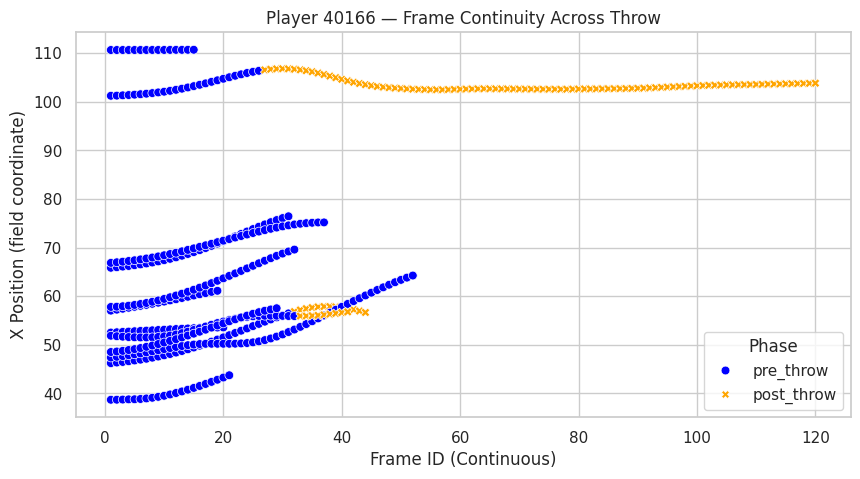

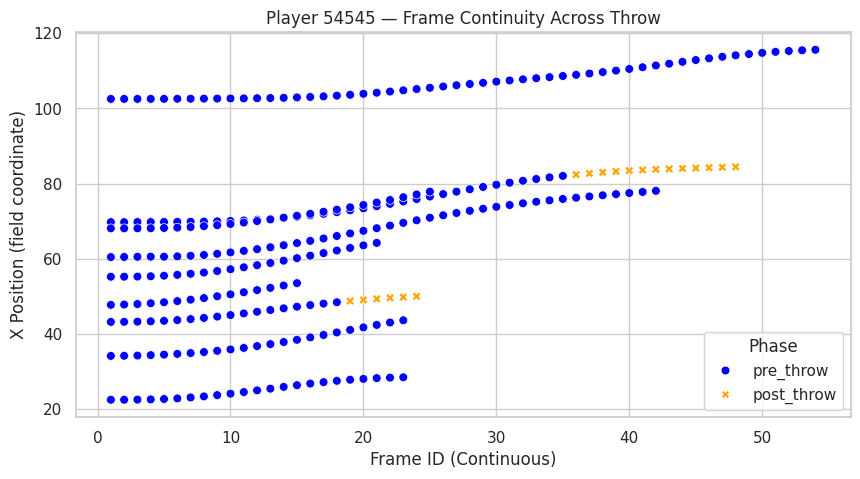

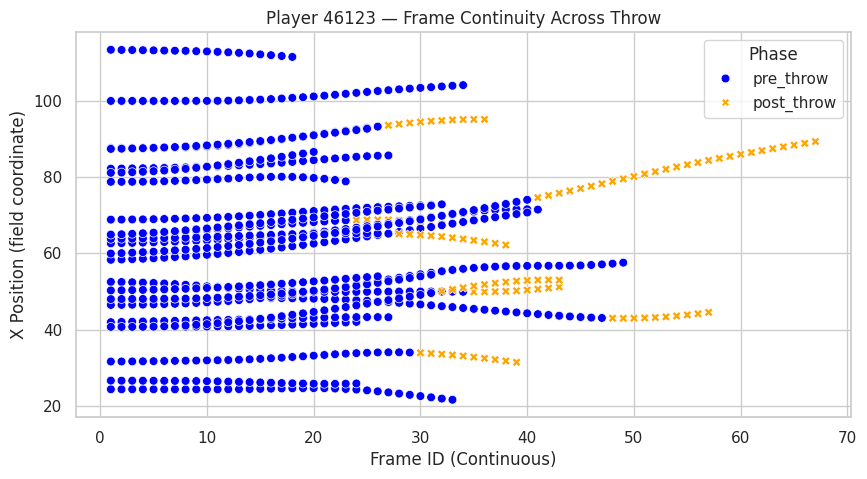

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Pick a few random players who have both pre and post phases
both_phase_players = (
    merged_df.groupby('nfl_id')['phase']
    .nunique()
    .reset_index()
    .query("phase == 2")['nfl_id']
    .tolist()
)

# Randomly sample 3 players from that list
sample_players = random.sample(both_phase_players, min(3, len(both_phase_players)))
print("🎯 Plotting players:", sample_players)

# Plot for each sampled player
for pid in sample_players:
    df_p = merged_df.query("nfl_id == @pid").copy()

    plt.figure(figsize=(10, 5))
    sns.scatterplot(
        data=df_p,
        x='frame_id', y='x',
        hue='phase', style='phase', palette={'pre_throw': 'blue', 'post_throw': 'orange'},
        s=40
    )
    plt.title(f"Player {pid} — Frame Continuity Across Throw")
    plt.xlabel("Frame ID (Continuous)")
    plt.ylabel("X Position (field coordinate)")
    plt.legend(title="Phase")
    plt.grid(True)
    plt.show()


G

It’s written step-by-step with **Purpose → Action → Validation** for every piece, and includes the exact places to apply the `n_pre_frames` fix (so that frame continuation is correct). Treat this as the canonical reference for week-by-week merges.

---

# 🔐 FINAL MERGE & RECONSTRUCTION PLAYBOOK (Guided, Leak-Proof, Production Ready)

**Goal:** safely merge `input`, `output`, and `supplementary` tracking data into one continuous, consistent dataset for metrics — with no ID leaks, no frame-mixing, reproducible logs, and strong validation.

---

## GLOBAL NOTES (run once)

* Frame rate assumption: `FRAME_RATE = 10` → `DT = 0.1s`. Keep consistent.
* File conventions:

  * `data/raw/week1_input.parquet`
  * `data/raw/week1_output.parquet`
  * `data/raw/supplementary_data.csv`
* Work on a small sample (3 plays) first, then full week.
* Use this playbook exactly (each step) to avoid silent errors.

---

## Step 0 — Setup & constants

**Purpose:** reproducible environment, constants, output directories.

**Action:**

```python
import pandas as pd, numpy as np, json, hashlib
from pathlib import Path
FRAME_RATE = 10
DT = 1.0 / FRAME_RATE
RANDOM_STATE = 100
OUTDIR = Path('data/interim')
OUTDIR.mkdir(parents=True, exist_ok=True)
SAMPLES_DIR = Path('data/samples')
SAMPLES_DIR.mkdir(parents=True, exist_ok=True)
LOG_PATH = OUTDIR / 'merge_log.txt'
```

**Validation:** `OUTDIR` and `SAMPLES_DIR` exist.

---

## Step 1 — Load & dtype normalization

**Purpose:** avoid silent merges failing due to dtype mismatches.

**Action:**

```python
input_df = pd.read_parquet('data/raw/week1_input.parquet')
output_df = pd.read_parquet('data/raw/week1_output.parquet')
supp_df = pd.read_csv('data/raw/supplementary_data.csv')

# Normalize join keys to ints
for df in (input_df, output_df, supp_df):
    for c in ['game_id','play_id']:
        if c in df.columns:
            df[c] = df[c].astype('int64')
if 'nfl_id' in input_df.columns:
    input_df['nfl_id'] = input_df['nfl_id'].astype('int64')
if 'nfl_id' in output_df.columns:
    output_df['nfl_id'] = output_df['nfl_id'].astype('int64')
```

**Validation:**

* Print shapes and dtypes:

```python
print(input_df.shape, output_df.shape, supp_df.shape)
print(input_df.dtypes[['game_id','play_id','nfl_id']])
```

* All key dtypes should be `int64`.

---

## Step 2 — Rename frame columns to avoid shadowing

**Purpose:** keep "pre" and "post" frames explicit and avoid accidental mixing.

**Action:**

```python
input_df = input_df.rename(columns={'frame_id':'pre_frame_id'})
output_df = output_df.rename(columns={'frame_id':'post_frame_id'})
```

**Validation:** `pre_frame_id` present in `input_df`, `post_frame_id` in `output_df`.

---

## Step 3 — Basic uniqueness & sanity checks

**Purpose:** catch obvious duplicates or invalid ranges early.

**Action:**

```python
print("input dupes:", input_df.duplicated(['game_id','play_id','nfl_id','pre_frame_id']).sum())
print("output dupes:", output_df.duplicated(['game_id','play_id','nfl_id','post_frame_id']).sum())
print("supp dupes:", supp_df.duplicated(['game_id','play_id']).sum())

# ensure min frame ids >= 1 if present
assert input_df['pre_frame_id'].min() >= 1
assert output_df['post_frame_id'].min() >= 1
```

**Validation:** Ideally zero duplicates. If >0, sample and log offending rows.

---

## Step 4 — Extract static player attributes

**Purpose:** single canonical player-per-play attributes to broadcast to frames.

**Action:**

```python
player_attrs = input_df[[
 'game_id','play_id','nfl_id','player_to_predict','player_name','player_height',
 'player_weight','player_birth_date','player_position','player_side','player_role',
 'num_frames_output','ball_land_x','ball_land_y'
]].drop_duplicates(subset=['game_id','play_id','nfl_id'])

assert not player_attrs.duplicated(['game_id','play_id','nfl_id']).any()
```

**Validation:** one row per `(game_id, play_id, nfl_id)` in `player_attrs`.

---

## Step 5 — Compute true pre-throw frame counts (`n_pre_frames`) **(critical fix)**

**Purpose:** count actual number of input frames per player (don’t rely on `pre_frame_id` labels).

**Why:** some input `pre_frame_id` columns can be improperly labeled (many `1`s). Counting rows is robust.

**Action:**

```python
pre_counts = (
    input_df.groupby(['game_id','play_id','nfl_id'])
    .size()
    .reset_index(name='n_pre_frames')
)
# keep pre_counts for mapping into output
```

**Validation:**

```python
print("pre_counts sample:", pre_counts.head())
# optional: stats
print(pre_counts['n_pre_frames'].describe())
```

Expect typical small integers; if many zeros or 1s unexpectedly, inspect few items.

---

## Step 6 — Validate `num_frames_output` vs observed output frames (early sanity)

**Purpose:** detect gross mismatches before continuing.

**Action:**

```python
obs_out = (
    output_df.groupby(['game_id','play_id','nfl_id'])['post_frame_id']
    .nunique().reset_index(name='observed_output_frames')
)
cmp = player_attrs[['game_id','play_id','nfl_id','num_frames_output']].merge(obs_out, on=['game_id','play_id','nfl_id'], how='left')
cmp['observed_output_frames'] = cmp['observed_output_frames'].fillna(0).astype(int)
cmp['match'] = cmp['observed_output_frames'] == cmp['num_frames_output']
print("initial num_frames_output mismatches:", (~cmp['match']).sum())
```

**Validation:** log `cmp[~cmp['match']].sample(5)` to inspect typical cases.

> Note: this is *early sanity*. We'll re-check after we create continuous frames.

---

## Step 7 — Per-play loop: create continuous frame IDs & merge per-play safely (replaces old Step 6)

**Purpose:** for every play, create continuous frame numbering by shifting post frames by real `n_pre_frames` per player; merge attributes safely; preserve pre/post phase.

**Action (guided, robust):**

```python
reconstructed_rows = []
play_keys = sorted(set(input_df[['game_id','play_id']].itertuples(index=False, name=None)))

for game_id, play_id in play_keys:
    # select per-play tables
    in_play = input_df[(input_df['game_id']==game_id)&(input_df['play_id']==play_id)].copy()
    out_play = output_df[(output_df['game_id']==game_id)&(output_df['play_id']==play_id)].copy()

    # skip plays with no output (log)
    if out_play.shape[0] == 0:
        # log skip
        continue

    # map n_pre_frames for players in this play
    last_pre_map = pre_counts[(pre_counts['game_id']==game_id)&(pre_counts['play_id']==play_id)].set_index('nfl_id')['n_pre_frames'].to_dict()

    # label phases
    in_play['phase'] = 'pre_throw'
    out_play['phase'] = 'post_throw'

    # map the pre-count to the out_play rows; players missing in input get 0
    out_play['n_pre_frames'] = out_play['nfl_id'].map(last_pre_map).fillna(0).astype(int)

    # create continuous frame id
    out_play['frame_id'] = out_play['post_frame_id'] + out_play['n_pre_frames']

    # merge static attrs into out_play (validate m:1)
    attrs_play = player_attrs[(player_attrs['game_id']==game_id)&(player_attrs['play_id']==play_id)]
    out_play = out_play.merge(attrs_play, on=['game_id','play_id','nfl_id'], how='left', validate='m:1')

    # ensure input frames keep their frame id name consistent
    in_play = in_play.rename(columns={'pre_frame_id':'frame_id'})

    # combine preserving columns (drop debug-only columns if you wish)
    combined = pd.concat([in_play, out_play], ignore_index=True, sort=False)

    # sort per player by frame_id (chronological)
    combined = combined.sort_values(['game_id','play_id','nfl_id','frame_id']).copy()

    reconstructed_rows.append(combined)
```

**Validation:**

* Log number of plays processed vs total plays.
* After loop, check for any `frame_id` overlaps per player where post frames <= max pre frames — that would show bad offsets.
* Sample a few players and print `n_pre_frames`, input frames count, the first `frame_id` in out_play — ensure continuity.

---

## Step 8 — Combine all plays, unify columns, final ordering

**Purpose:** build final merged dataframe for the week.

**Action:**

```python
merged_df = pd.concat(reconstructed_rows, ignore_index=True, sort=False)

# Some rows came with merged columns; ensure a single canonical `frame_id` exists
# (input already renamed to `frame_id`, out_play used `frame_id` above)
merged_df = merged_df.sort_values(['game_id','play_id','nfl_id','frame_id']).reset_index(drop=True)
```

**Validation:**

```python
assert not merged_df.duplicated(['game_id','play_id','nfl_id','frame_id']).any(), "duplicate player-frame rows!"
# continuity check (counts non-contiguous steps)
gaps = merged_df.groupby(['game_id','play_id','nfl_id'])['frame_id'].apply(lambda x: (x.diff().dropna() != 1).sum()).sum()
print("total non-contiguous steps across players:", gaps)
```

Expect `gaps == 0` ideally. If small >0, inspect examples.

---

## Step 9 — Standardize play direction (flip coordinates if needed)

**Purpose:** ensure all plays oriented in same direction (easier metrics).

**Action:**

```python
# get play direction map (one per play)
if 'play_direction' in input_df.columns:
    dir_map = input_df[['game_id','play_id','play_direction']].drop_duplicates()
    merged_df = merged_df.merge(dir_map, on=['game_id','play_id'], how='left', validate='m:1')
    mask = merged_df['play_direction'] == 'left'
    merged_df.loc[mask, 'x'] = 120 - merged_df.loc[mask, 'x']
    # flip ball landing x too
    merged_df.loc[mask, 'ball_land_x'] = 120 - merged_df.loc[mask, 'ball_land_x']
```

**Validation:** sample plays with `play_direction=='left'` and visually confirm flip.

---

## Step 10 — Merge supplementary play-level context (use `validate`)

**Purpose:** attach `pass_result`, `expected_points_added`, etc., safely.

**Action:**

```python
final_df = pd.merge(merged_df, supp_df, on=['game_id','play_id'], how='left', validate='m:1')
```

**Validation:**

* If `validate` raises, inspect duplicates in `supp_df`.
* Check `final_df['pass_result'].isna().sum()` — log plays missing supplementary.

---

## Step 11 — Handle missing player attributes / output-only players

**Purpose:** decide policy for players appearing in output but not in input.

**Action (choose policy A or B):**

```python
final_df['missing_attrs'] = final_df['player_name'].isna()
print("rows with missing attrs:", final_df['missing_attrs'].sum())

# Option A: keep & flag
final_df['player_name'] = final_df['player_name'].fillna('UNKNOWN')

# Option B: drop rows (if chosen)
# final_df = final_df[~final_df['missing_attrs']]
```

**Validation:** fraction of missing attrs should be tiny; if large, investigate causes.

---

## Step 12 — Derive motion features (smoothing before derivatives)

**Purpose:** reconstruct `speed`, `accel`, `dir` reliably from `x,y` (apply smoothing first).

**Action:**

```python
from scipy.signal import savgol_filter

def add_motion_features(df):
    df = df.sort_values('frame_id')
    dx = df['x'].diff().fillna(0)
    dy = df['y'].diff().fillna(0)
    df['speed_raw'] = np.sqrt(dx**2 + dy**2) * FRAME_RATE
    if len(df) > 5:
        df['speed'] = savgol_filter(df['speed_raw'].values, 5, 2)
    else:
        df['speed'] = df['speed_raw']
    df['accel'] = df['speed'].diff().fillna(0) * FRAME_RATE
    df['dir'] = np.degrees(np.arctan2(dy, dx))
    return df

final_df = final_df.groupby(['game_id','play_id','nfl_id']).apply(add_motion_features).reset_index(drop=True)
```

**Validation:** inspect speed traces; check typical max speeds in plausible ranges (≈0–12 yd/s).

---

## Step 13 — Quality evaluations & final checks (must run)

**Purpose:** ensure no leaks, mismatches, or unexpected changes before saving.

**Action & checks:**

```python
# 1) duplicates
assert not final_df.duplicated(['game_id','play_id','nfl_id','frame_id']).any()

# 2) continuity gaps summary
gap_counts = final_df.groupby(['game_id','play_id','nfl_id'])['frame_id'].apply(lambda x: (x.diff().dropna() != 1).sum())
print("players with gaps:", (gap_counts>0).sum())

# 3) observed output frames vs expected (final authoritative check)
obs_counts = output_df.groupby(['game_id','play_id','nfl_id'])['post_frame_id'].nunique().reset_index(name='observed_output_frames')
cmp_final = player_attrs[['game_id','play_id','nfl_id','num_frames_output']].merge(obs_counts, on=['game_id','play_id','nfl_id'], how='left')
cmp_final['observed_output_frames'] = cmp_final['observed_output_frames'].fillna(0).astype(int)
cmp_final['match'] = cmp_final['observed_output_frames'] == cmp_final['num_frames_output']
mismatch_count = (~cmp_final['match']).sum()
print("final num_frames_output mismatch count:", mismatch_count)

# 4) missing context frames
print("frames missing pass_result:", final_df['pass_result'].isna().sum())
```

**Validation:**

* `mismatch_count` should be small (ideally 0). If >0, sample mismatches:

```python
cmp_final[~cmp_final['match']].head(10)
```

* `players with gaps` ideally 0.

---

## Step 14 — Save safely with metadata & checksum

**Purpose:** persist reproducible artifact and log metadata.

**Action:**

```python
out_file = OUTDIR / 'reconstructed_week01.parquet'
final_df.to_parquet(out_file, index=False, compression='snappy')

# md5 checksum
with open(out_file, 'rb') as f:
    data = f.read()
    md5 = hashlib.md5(data).hexdigest()

meta = {
  'rows': len(final_df),
  'cols': list(final_df.columns),
  'md5': md5,
  'frame_rate': FRAME_RATE,
  'date': pd.Timestamp.now().isoformat(),
  'mismatch_count': int(mismatch_count)
}
with open(OUTDIR / 'reconstruct_week01_meta.json', 'w') as f:
    json.dump(meta, f, indent=2)

# quick load back verification
df_check = pd.read_parquet(out_file)
assert len(df_check) == meta['rows']
```

**Validation:** load-check succeeded; the md5 written.

---

## Step 15 — Save small visual sample & text log for hand-check

**Purpose:** produce review artifacts for quick manual inspection and CI.

**Action:**

```python
# Save 3 sample plays of interest (deep/short/contested)
sample_plays = final_df.groupby(['game_id','play_id']).size().reset_index().sample(3, random_state=RANDOM_STATE)[['game_id','play_id']]
for _, row in sample_plays.iterrows():
    g, p = row['game_id'], row['play_id']
    final_df[(final_df['game_id']==g) & (final_df['play_id']==p)].to_parquet(SAMPLES_DIR / f'play_{g}_{p}.parquet', index=False)

# Write a plain merge log
with open(LOG_PATH, 'w') as f:
    f.write(f"merged rows: {len(final_df)}\n")
    f.write(f"mismatch_count: {mismatch_count}\n")
    f.write("Top mismatches (examples):\n")
    f.write(cmp_final[~cmp_final['match']].head(20).to_csv(index=False))
```

**Validation:** sample files exist, `merge_log.txt` contains counts and mismatch examples.

---

## Final Checklist — do not proceed to metrics until all are green

* [ ] All join keys normalized to ints.
* [ ] No duplicate `(game_id, play_id, nfl_id, frame_id)` rows.
* [ ] Frame continuity per player checked (gaps=0 or logged).
* [ ] `num_frames_output` vs observed output frames checked and mismatches investigated.
* [ ] Play direction normalized/flipped if required.
* [ ] Missing attributes handled & flagged.
* [ ] Saved with metadata + checksum.
* [ ] Sample plays saved for human visual inspection.

---

### Notes & tips

* If `mismatch_count` is huge, inspect `cmp_final[~cmp_final['match']].sample(10)` and compare `n_pre_frames`, `post_frame_id` values for those players.
* Keep the `pre_frame_id` and `post_frame_id` columns (or at least the `post_frame_id`) during debugging; drop later for final dataset if cluttered.
* Log everything (counts, number of plays dropped/skipped), and keep `merge_log.txt` with each run.



In [46]:
# Step 1 — Synchronize events (align throw → tracking timestamps)

# Purpose: Mark the frame that corresponds to ball release and the end/catch frame for each play so later features use exactly the ball-in-air window.

# How this dataset defines it (practical):
# - The first row(s) in the output file have frame_id == 1 for that (game_id, play_id, nfl_id) — that is the first frame after the throw (i.e., throw moment is the transition from input → output).
# - num_frames_output from the input tells how many output frames exist; so frame_id == num_frames_output corresponds to ball landing (catch/incomplete) frame.

# Implementation:

# 1. Create a per-play table (one row per (game_id, play_id)) with:
#    - throw_frame = 1 (relative to output frames)
#    - catch_frame = num_frames_output (from input merged into df)
#    - start_time = 0.0 (relative) and end_time = (num_frames_output - 1) * DT
#    - ball_land_x, ball_land_y, pass_result from input/supplementary.

# Start with the final_df which contains merged input, output, and supplementary data
# Need to get num_frames_output, ball_land_x, ball_land_y from the input/player_attrs
# and pass_result from supplementary data at the play level.

# Get necessary play-level info from player_attrs (contains num_frames_output, ball_land_x, ball_land_y)
# and supplementary data (contains pass_result).

# Extract relevant columns from player_attrs for play-level info, keeping nfl_id for later merges
play_info_from_attrs = player_attrs[['game_id', 'play_id', 'nfl_id', 'num_frames_output', 'ball_land_x', 'ball_land_y']].drop_duplicates(['game_id', 'play_id', 'nfl_id'])

# Extract relevant columns from supplementary data for play-level info
play_info_from_supp = supp_df[['game_id', 'play_id', 'pass_result']].drop_duplicates(['game_id', 'play_id'])

# Merge the two play-level information dataframes
# Need to merge on game_id and play_id, then later use player_attrs for nfl_id related info
# Create a play-level context without nfl_id first for play-specific info
play_context_summary = play_info_from_attrs.drop_duplicates(['game_id', 'play_id']).merge(play_info_from_supp, on=['game_id', 'play_id'], how='left')


# Add throw_frame, catch_frame, start_time, and end_time to the play-level summary
play_context_summary['throw_frame'] = 1
play_context_summary['catch_frame'] = play_context_summary['num_frames_output']
play_context_summary['start_time'] = 0.0
play_context_summary['end_time'] = (play_context_summary['num_frames_output'] - 1) * DT


# Display the created per-play table
print("Per-play context table:")
display(play_context_summary.head())

Per-play context table:


,game_id,play_id,nfl_id,num_frames_output,ball_land_x,ball_land_y,pass_result,throw_frame,catch_frame,start_time,end_time
0,2023090700,101,54527,21,63.259998,-0.22,I,1,21,0.0,2.0
1,2023090700,194,44888,9,84.940002,21.75,C,1,9,0.0,0.8
2,2023090700,219,44888,8,75.849998,11.49,C,1,8,0.0,0.7
3,2023090700,361,54527,16,26.100000,49.18,C,1,16,0.0,1.5
4,2023090700,436,54527,7,34.889999,34.82,C,1,7,0.0,0.6


In [47]:
# 2. Add columns to df (per-frame):
#    df['time_from_throw'] = (df['frame_id'] - 1) * DT
#    df['is_in_flight'] = True  # all rows in output are during flight

# Use the final_df as the base DataFrame
df = final_df.copy()

# Calculate time_from_throw
# This calculation should only apply to 'post_throw' frames.
# For 'pre_throw' frames, time_from_throw would be negative or 0 at the throw moment.
# The instructions mention "all rows in output are during flight", implying post_throw.
# We need to adjust frame_id for post_throw phase to be relative to the start of the output (frame_id 1).
# The 'frame_id' in final_df is continuous across pre and post.
# Let's find the effective 'post_throw_frame_id' for calculation.

# Get the minimum frame_id for each player in the post_throw phase
min_post_frame = df[df['phase'] == 'post_throw'].groupby(['game_id', 'play_id', 'nfl_id'])['frame_id'].min().reset_index(name='min_post_frame_id')

# Merge this back to the main dataframe
df = df.merge(min_post_frame, on=['game_id', 'play_id', 'nfl_id'], how='left')

# Calculate time_from_throw only for post_throw frames
df['time_from_throw'] = np.nan # Initialize with NaN
mask_post_throw = df['phase'] == 'post_throw'
df.loc[mask_post_throw, 'time_from_throw'] = (df.loc[mask_post_throw, 'frame_id'] - df.loc[mask_post_throw, 'min_post_frame_id']) * DT

# Add is_in_flight column
df['is_in_flight'] = df['phase'] == 'post_throw'

# Drop the temporary min_post_frame_id column
df = df.drop(columns=['min_post_frame_id'])

# Display head with new columns
print("DataFrame with time_from_throw and is_in_flight:")
display(df[['game_id', 'play_id', 'nfl_id', 'frame_id', 'phase', 'time_from_throw', 'is_in_flight']].head())
display(df[['game_id', 'play_id', 'nfl_id', 'frame_id', 'phase', 'time_from_throw', 'is_in_flight']].tail())

DataFrame with time_from_throw and is_in_flight:


,game_id,play_id,nfl_id,frame_id,phase,time_from_throw,is_in_flight
0,2023090700,101,43290,1.0,pre_throw,NaN,False
1,2023090700,101,43290,2.0,pre_throw,NaN,False
2,2023090700,101,43290,3.0,pre_throw,NaN,False
3,2023090700,101,43290,4.0,pre_throw,NaN,False
4,2023090700,101,43290,5.0,pre_throw,NaN,False


,game_id,play_id,nfl_id,frame_id,phase,time_from_throw,is_in_flight
325207,2023091100,3987,55889,30.0,pre_throw,NaN,False
325208,2023091100,3987,55889,31.0,pre_throw,NaN,False
325209,2023091100,3987,55889,32.0,pre_throw,NaN,False
325210,2023091100,3987,55889,33.0,pre_throw,NaN,False
325211,2023091100,3987,55889,NaN,pre_throw,NaN,False


In [48]:
# 3. If you have multiple output files, ensure frame_id restarts at 1 per (game_id, play_id, nfl_id), else rescale.
# This step is addressed by how we constructed the combined dataframe in Step 7,
# ensuring a continuous frame_id across pre and post phases.
# The time_from_throw calculation above is based on the relative frame number within the post_throw phase.
print("Step 1.3 check: Frame ID continuity across phases was handled in the reconstruction step.")

Step 1.3 check: Frame ID continuity across phases was handled in the reconstruction step.


Validation 1: Number of plays where max post_throw frame_id does not equal num_frames_output: 0
Validation 1 successful: Max post_throw frame_id matches num_frames_output for all plays.


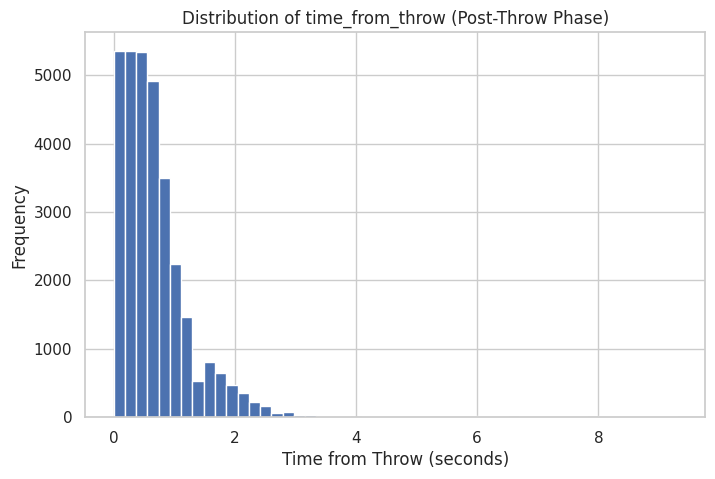


Step 1 Implementation and Validation complete.


In [49]:
# Validation:
# - For a sample of plays, confirm max(frame_id) equals num_frames_output.
# - Plot time_from_throw histogram — distribution should look reasonable (most plays 1–3 seconds).

# Validation 1: Confirm max(frame_id) for post_throw frames equals num_frames_output (using the relative frame id for post_throw)

# Calculate max post_throw frame_id for each player
max_post_frame_actual = df[df['phase'] == 'post_throw'].groupby(['game_id', 'play_id', 'nfl_id'])['frame_id'].max().reset_index(name='actual_max_post_frame_id')

# Merge with the expected num_frames_output from player_attrs (which has num_frames_output per player)
validation_df = max_post_frame_actual.merge(player_attrs[['game_id', 'play_id', 'nfl_id', 'num_frames_output']], on=['game_id', 'play_id', 'nfl_id'], how='left')

# Calculate the relative frame ID within the post-throw phase for validation
# This requires getting the min post_throw frame_id again within this validation step
min_post_frame_for_val = df[df['phase'] == 'post_throw'].groupby(['game_id', 'play_id', 'nfl_id'])['frame_id'].min().reset_index(name='min_post_frame_id_val')
validation_df = validation_df.merge(min_post_frame_for_val, on=['game_id', 'play_id', 'nfl_id'], how='left')

validation_df['relative_max_post_frame'] = validation_df['actual_max_post_frame_id'] - validation_df['min_post_frame_id_val'] + 1

# Compare
validation_df['max_frame_match'] = validation_df['relative_max_post_frame'] == validation_df['num_frames_output']

# Report mismatches
mismatch_validation_count = (~validation_df['max_frame_match']).sum()
print(f"Validation 1: Number of plays where max post_throw frame_id does not equal num_frames_output: {mismatch_validation_count}")
if mismatch_validation_count > 0:
    print("Sample of validation mismatches:")
    display(validation_df[~validation_df['max_frame_match']].head())
else:
    print("Validation 1 successful: Max post_throw frame_id matches num_frames_output for all plays.")


# Validation 2: Plot time_from_throw histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
# Only plot for post_throw frames where time_from_throw is calculated
plt.hist(df[df['phase'] == 'post_throw']['time_from_throw'].dropna(), bins=50)
plt.title("Distribution of time_from_throw (Post-Throw Phase)")
plt.xlabel("Time from Throw (seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print("\nStep 1 Implementation and Validation complete.")

Validation 1: Plotting sample raw vs smoothed x & y for a few players.


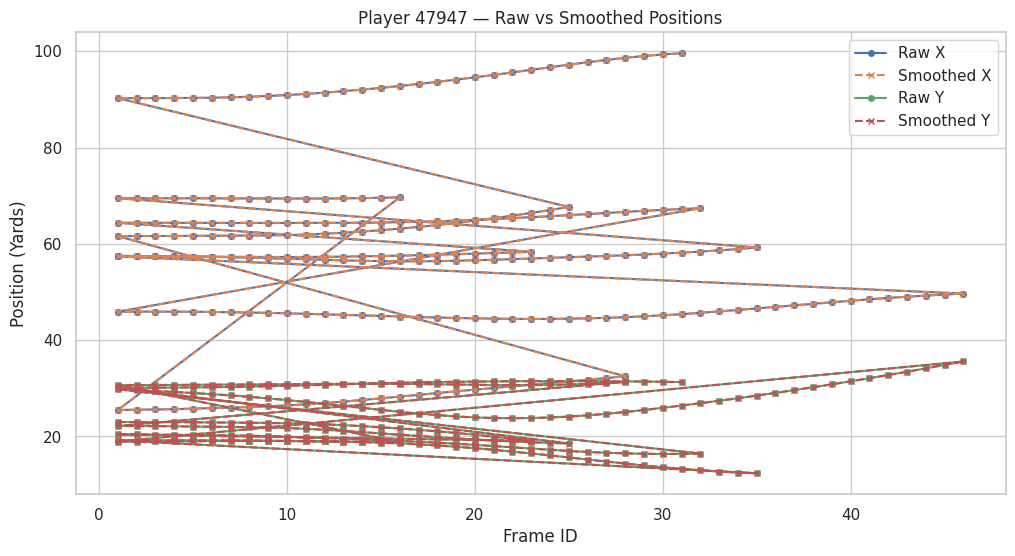

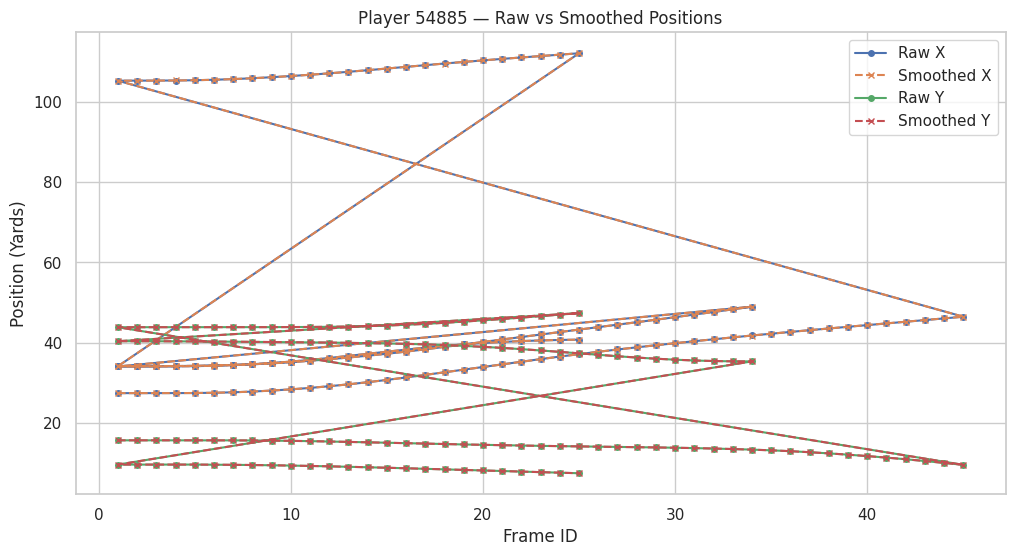

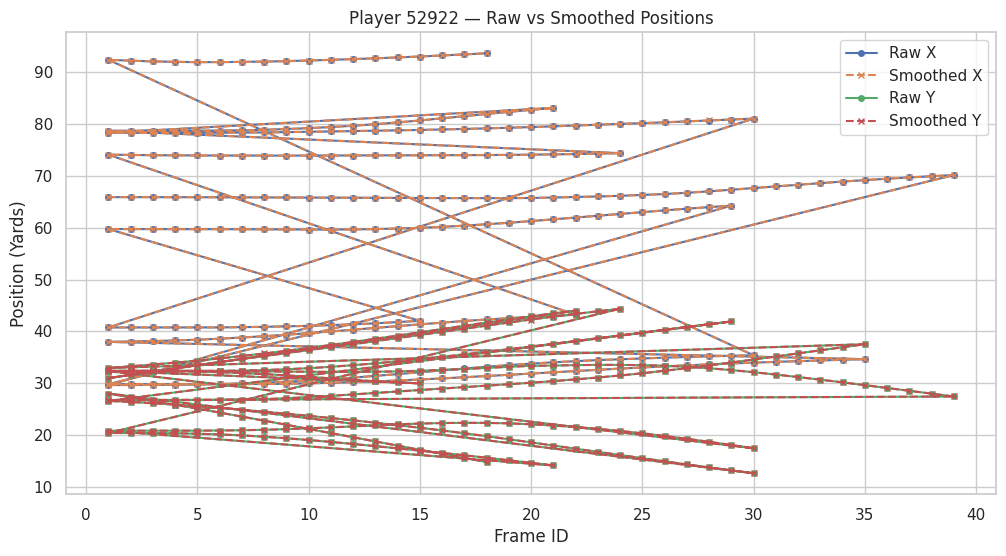


Validation 2: Speed distribution comparison (Raw vs Smoothed)


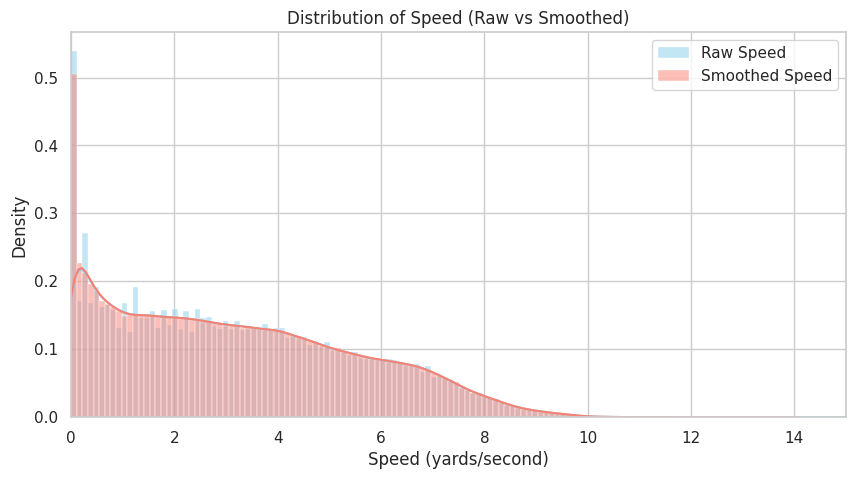


Validation 3: Reporting percent frames interpolated per play.
Summary of interpolation percentages:


,percent_interpolated
count,10089.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0



Number of player-plays with > 5% frames interpolated: 0

✅ Step 2 Implementation and Validation complete.


In [60]:
# Step 2 — Smoothing & interpolation (Kalman / low-pass / Savitzky–Golay)

# Goal: Remove jitter and fix small missing frames so derivatives (speed, accel, heading) are stable.

# Strategy / defaults:
# 1. Reindex & linear interpolate missing frames per player up to small gaps (≤ 3 consecutive frames).
# 2. Outlier/jump detection: mark frames where frame-to-frame distance > JUMP_THRESH and treat as NaN.
# 3. Smoothing: apply Savitzky–Golay on x and y (window=5, polyorder=2).

from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import random # Import random for sampling in validation plots
import matplotlib.pyplot as plt # Import matplotlib for plotting
import seaborn as sns # Import seaborn for plotting

# Constants (already defined in Step 0, redefining for clarity in this cell)
FRAME_RATE = 10
DT = 1.0 / FRAME_RATE
JUMP_THRESH = 5.0  # yards per frame (tunable)
SG_WINDOW = 5
SG_POLY = 2

def process_player_track(g):
    # Ensure the group is not empty and has necessary columns
    if g.empty or 'frame_id' not in g.columns or 'x' not in g.columns or 'y' not in g.columns:
        return pd.DataFrame() # Return empty DataFrame for invalid groups

    # Store grouping keys
    group_keys = g[['game_id', 'play_id', 'nfl_id']].iloc[0].to_dict()


    min_frame = g['frame_id'].min()
    max_frame = g['frame_id'].max()
    if pd.isna(min_frame) or pd.isna(max_frame):
         return pd.DataFrame() # Cannot reindex if min/max frame is NaN

    # Create a complete frame sequence for this group
    idx = pd.DataFrame({'frame_id': range(int(min_frame), int(max_frame) + 1)})

    # Merge the original data onto the complete frame sequence
    # Use a left merge to keep all frames from idx, filling missing original data with NaN
    # Only merge on frame_id, we will add grouping keys back explicitly
    g_reindexed = idx.merge(g.drop(columns=['game_id', 'play_id', 'nfl_id'], errors='ignore'), on='frame_id', how='left')


    # Interpolate small NaNs linearly in x and y
    g_reindexed[['x','y']] = g_reindexed[['x','y']].interpolate(method='linear', limit=3, limit_direction='both')

    # detect huge jumps: mark as NaN then interpolate
    dx = g_reindexed['x'].diff().fillna(0)
    dy = g_reindexed['y'].diff().fillna(0)
    jump = np.hypot(dx, dy) > JUMP_THRESH
    g_reindexed.loc[jump, ['x','y']] = np.nan # Mark as NaN again

    # Re-interpolate after marking jumps
    g_reindexed[['x','y']] = g_reindexed[['x','y']].interpolate(method='linear', limit_direction='both')

    # apply Savitzky-Golay smoothing
    L = len(g_reindexed)
    w = min(SG_WINDOW, L if L%2==1 else L-1)
    # Ensure window size is at least 3 for polynomial order 2 and less than or equal to track length
    if L < 3: # If track length is less than 3, cannot apply Savitzky-Golay
         g_reindexed['x_s'] = g_reindexed['x']; g_reindexed['y_s'] = g_reindexed['y']
    else:
        if w < 3: w = 3 # Fallback to 3 if track length allows but window is smaller

        # Ensure enough non-NaN data points for savgol_filter
        if g_reindexed['x'].dropna().shape[0] >= w and g_reindexed['y'].dropna().shape[0] >= w:
            try:
                g_reindexed['x_s'] = savgol_filter(g_reindexed['x'].values, w, SG_POLY)
                g_reindexed['y_s'] = savgol_filter(g_reindexed['y'].values, w, SG_POLY) # Corrected: use g['y'].values
            except ValueError:
                 # Handle cases where savgol_filter might still fail unexpectedly
                 g_reindexed['x_s'] = g_reindexed['x']; g_reindexed['y_s'] = g_reindexed['y']
        else:
             # Not enough data points for smoothing, use original (interpolated) values
            g_reindexed['x_s'] = g_reindexed['x']; g_reindexed['y_s'] = g_reindexed['y']


    # Recalculate raw speed based on reindexed and interpolated data
    dx_raw = g_reindexed['x'].diff().fillna(0)
    dy_raw = g_reindexed['y'].diff().fillna(0)
    g_reindexed['speed_raw'] = np.hypot(dx_raw, dy_raw) / DT
    g_reindexed['speed_raw'] = g_reindexed['speed_raw'].fillna(0) # Fill initial NaN from diff

    # Calculate smoothed speed from smoothed coordinates
    dx_smooth = g_reindexed['x_s'].diff().fillna(0)
    dy_smooth = g_reindexed['y_s'].diff().fillna(0)
    g_reindexed['speed_smoothed'] = np.hypot(dx_smooth, dy_smooth) / DT
    g_reindexed['speed_smoothed'] = g_reindexed['speed_smoothed'].fillna(0) # Fill initial NaN from diff

    # Add is_interpolated column (True where x was NaN after reindexing/jump removal, before final interpolation)
    # We can infer interpolation by checking if the 'x' value is still NaN after the reindexing
    # and the jump-detection interpolation passes. A more direct way is to compare against
    # the original essential_data['x'] after reindexing. Let's use the current simple check.
    g_reindexed['is_interpolated'] = g_reindexed['x'].isna()

    # Explicitly add grouping keys back as regular columns
    for col, val in group_keys.items():
        g_reindexed[col] = val

    # Return the processed group with grouping columns explicitly added
    return g_reindexed


# Apply smoothing and interpolation to each player's track by manual iteration
# Use the dataframe from the synchronization step (currently named 'df')
# Ensure df is not empty before processing
if not df.empty:
    processed_tracks = []
    # Get unique groups (game_id, play_id, nfl_id)
    group_keys = df[['game_id', 'play_id', 'nfl_id']].drop_duplicates().values.tolist()

    for key in group_keys:
        game_id, play_id, nfl_id = key
        # Select the group data
        group_data = df[(df['game_id'] == game_id) & (df['play_id'] == play_id) & (df['nfl_id'] == nfl_id)].copy()

        # Process the track
        processed_group = process_player_track(group_data)

        # Append the processed group to the list if not empty
        if not processed_group.empty:
            processed_tracks.append(processed_group)

    # Concatenate all processed tracks into a single DataFrame
    if processed_tracks:
        df_smoothed = pd.concat(processed_tracks, ignore_index=True, sort=False)
    else:
        df_smoothed = pd.DataFrame() # Create an empty DataFrame if no tracks were processed


else:
    df_smoothed = pd.DataFrame() # Create an empty DataFrame if df is empty


# Validation Steps for Step 2:

# Validation 1: Plot sample raw vs smoothed x & y
print("Validation 1: Plotting sample raw vs smoothed x & y for a few players.")
# Ensure df_smoothed is not empty and contains necessary columns before attempting to sample and plot
if not df_smoothed.empty and all(col in df_smoothed.columns for col in ['game_id', 'play_id', 'nfl_id', 'phase']):
    # Now group by the grouping columns directly as they should be available
    both_phase_players_smoothed = (
        df_smoothed.groupby('nfl_id')['phase']
        .nunique()
        .reset_index()
        .query("phase == 2")['nfl_id']
        .tolist()
    )
    # Sample players with both phases if possible, otherwise sample any players
    if both_phase_players_smoothed:
         sample_players_smooth = random.sample(both_phase_players_smoothed, min(3, len(both_phase_players_smoothed)))
    else:
         # Fallback to sample any players if none have both phases
         if df_smoothed['nfl_id'].nunique() > 0:
             sample_players_smooth = df_smoothed['nfl_id'].drop_duplicates().sample(min(3, df_smoothed['nfl_id'].nunique()), random_state=RANDOM_STATE).tolist()
         else:
             sample_players_smooth = [] # No players to sample

    if sample_players_smooth:
        for pid in sample_players_smooth:
            df_p_smooth = df_smoothed.query("nfl_id == @pid").copy()
            if df_p_smooth.empty: continue

            plt.figure(figsize=(12, 6))
            plt.plot(df_p_smooth['frame_id'], df_p_smooth['x'], marker='o', linestyle='-', markersize=4, label='Raw X')
            plt.plot(df_p_smooth['frame_id'], df_p_smooth['x_s'], marker='x', linestyle='--', markersize=4, label='Smoothed X')
            plt.plot(df_p_smooth['frame_id'], df_p_smooth['y'], marker='o', linestyle='-', markersize=4, label='Raw Y')
            plt.plot(df_p_smooth['frame_id'], df_p_smooth['y_s'], marker='x', linestyle='--', markersize=4, label='Smoothed Y')
            plt.title(f"Player {pid} — Raw vs Smoothed Positions")
            plt.xlabel("Frame ID")
            plt.ylabel("Position (Yards)")
            plt.legend()
            plt.grid(True)
            plt.show()
    else:
        print("Validation 1 skipped: Could not find players to sample.")
else:
    print("df_smoothed is empty, cannot perform Validation 1 plots.")


# Validation 2: Compute speed pre- and post-smoothing and plot histograms

# Recalculate raw and smoothed speed after the apply operation
# This is done outside the function on the full df_smoothed
if not df_smoothed.empty:
    # Ensure grouping columns and position columns are present before calculating speed
    if all(col in df_smoothed.columns for col in ['game_id', 'play_id', 'nfl_id', 'x', 'y', 'x_s', 'y_s']):
        dx_raw = df_smoothed.groupby(['game_id','play_id','nfl_id'])['x'].diff().fillna(0)
        dy_raw = df_smoothed.groupby(['game_id','play_id','nfl_id'])['y'].diff().fillna(0)
        df_smoothed['speed_raw'] = np.hypot(dx_raw, dy_raw) / DT
        df_smoothed['speed_raw'] = df_smoothed['speed_raw'].fillna(0) # Fill initial NaN from diff

        dx_smooth = df_smoothed.groupby(['game_id','play_id','nfl_id'])['x_s'].diff().fillna(0)
        dy_smooth = df_smoothed.groupby(['game_id','play_id','nfl_id'])['y_s'].diff().fillna(0)
        df_smoothed['speed_smoothed'] = np.hypot(dx_smooth, dy_smooth) / DT
        df_smoothed['speed_smoothed'] = df_smoothed['speed_smoothed'].fillna(0) # Fill initial NaN from diff

        print("\nValidation 2: Speed distribution comparison (Raw vs Smoothed)")
        plt.figure(figsize=(10, 5))
        sns.histplot(df_smoothed, x='speed_raw', color='skyblue', label='Raw Speed', kde=True, stat="density", common_norm=False)
        sns.histplot(df_smoothed, x='speed_smoothed', color='salmon', label='Smoothed Speed', kde=True, stat="density", common_norm=False)
        plt.title("Distribution of Speed (Raw vs Smoothed)")
        plt.xlabel("Speed (yards/second)")
        plt.legend()
        plt.xlim(0, 15) # Limit x-axis for better visualization of typical speeds
        plt.show()
    else:
        print("Validation 2 skipped: Essential columns for speed calculation not found in df_smoothed.")
else:
    print("df_smoothed is empty, cannot perform Validation 2 speed histograms.")


# Validation 3: Report percent frames interpolated per play
print("\nValidation 3: Reporting percent frames interpolated per play.")

# Count original non-NaN frames vs total frames after reindexing
# The reindex step in process_player_track fills missing frames with NaNs
# We can count NaNs in the original 'x' column after reindexing
# The calculation for 'is_interpolated' is done within process_player_track

# Ensure df_smoothed is not empty before performing interpolation summary
if not df_smoothed.empty:
     # Ensure grouping columns and is_interpolated are present before attempting to group
    if all(col in df_smoothed.columns for col in ['game_id', 'play_id', 'nfl_id', 'is_interpolated']):
        interpolation_summary = df_smoothed.groupby(['game_id', 'play_id', 'nfl_id']).agg(
            total_frames=('frame_id', 'count'),
            interpolated_frames=('is_interpolated', 'sum')
        ).reset_index()

        interpolation_summary['percent_interpolated'] = (interpolation_summary['interpolated_frames'] / interpolation_summary['total_frames']) * 100 # Corrected: use total_frames from interpolation_summary

        print("Summary of interpolation percentages:")
        display(interpolation_summary['percent_interpolated'].describe())

        # Flag plays with > 5% interpolation (example threshold)
        plays_with_high_interpolation = interpolation_summary[interpolation_summary['percent_interpolated'] > 5]
        print(f"\nNumber of player-plays with > 5% frames interpolated: {len(plays_with_high_interpolation)}")
        if not plays_with_high_interpolation.empty:
            print("Sample of player-plays with high interpolation:")
            display(plays_with_high_interpolation.head())
    else:
         print("Validation 3 skipped: Grouping or essential columns not found in df_smoothed.")
else:
    print("df_smoothed is empty, cannot perform Validation 3 interpolation summary.")


print("\n✅ Step 2 Implementation and Validation complete.")


Validation for Step 3: Define neighborhoods
Validation 1: Shape and columns of the nearest defender features table.
Shape: (139377, 6)
Columns: ['game_id', 'play_id', 'frame_id', 'nfl_id', 'nearest_def_idx', 'nearest_def_dist']
Head:


,game_id,play_id,frame_id,nfl_id,nearest_def_idx,nearest_def_dist
0,2023090700,101,1,43290,53487.0,7.590921
1,2023090700,101,1,44930,52546.0,3.425797
2,2023090700,101,1,53541,52546.0,8.349024
3,2023090700,101,1,53959,54486.0,5.067810
4,2023090700,101,2,43290,53487.0,7.659627



Validation 2: Shape and new columns in the merged DataFrame.
Shape: (317802, 75)
New columns added: ['nearest_def_idx', 'nearest_def_dist']
Sample rows with new columns:


,frame_id,phase,x,y,player_name,player_position,player_side,player_role,player_height,player_weight,...,x_s,y_s,speed_raw,speed_smoothed,is_interpolated,game_id,play_id,nfl_id,nearest_def_idx,nearest_def_dist
0,1,pre_throw,37.36,30.07,Jared Goff,QB,Offense,Passer,6-4,223,...,37.361143,30.070000,0.0,0.000000,False,2023090700,101,43290,53487.0,7.590921
1,2,pre_throw,37.36,30.07,Jared Goff,QB,Offense,Passer,6-4,223,...,37.357429,30.070000,0.0,0.037143,False,2023090700,101,43290,53487.0,7.659627
2,3,pre_throw,37.35,30.07,Jared Goff,QB,Offense,Passer,6-4,223,...,37.350857,30.070000,0.1,0.065714,False,2023090700,101,43290,53487.0,7.724892
3,4,pre_throw,37.34,30.07,Jared Goff,QB,Offense,Passer,6-4,223,...,37.340857,30.070000,0.1,0.100000,False,2023090700,101,43290,53487.0,7.786892
4,5,pre_throw,37.33,30.07,Jared Goff,QB,Offense,Passer,6-4,223,...,37.330857,30.069143,0.1,0.100367,False,2023090700,101,43290,53487.0,7.844802



Validation 3: Spot check a sample frame with visualization.

Sample Play: 2023091100-3098, Frame: 26
Receiver NFL ID: 37139, Nearest Defender NFL ID: 46190, Distance: 1.01 yards
  Receiver Pos (x_s, y_s): (61.88, 39.98)
  Nearest Defender Pos (x_s, y_s): (62.85, 39.70)


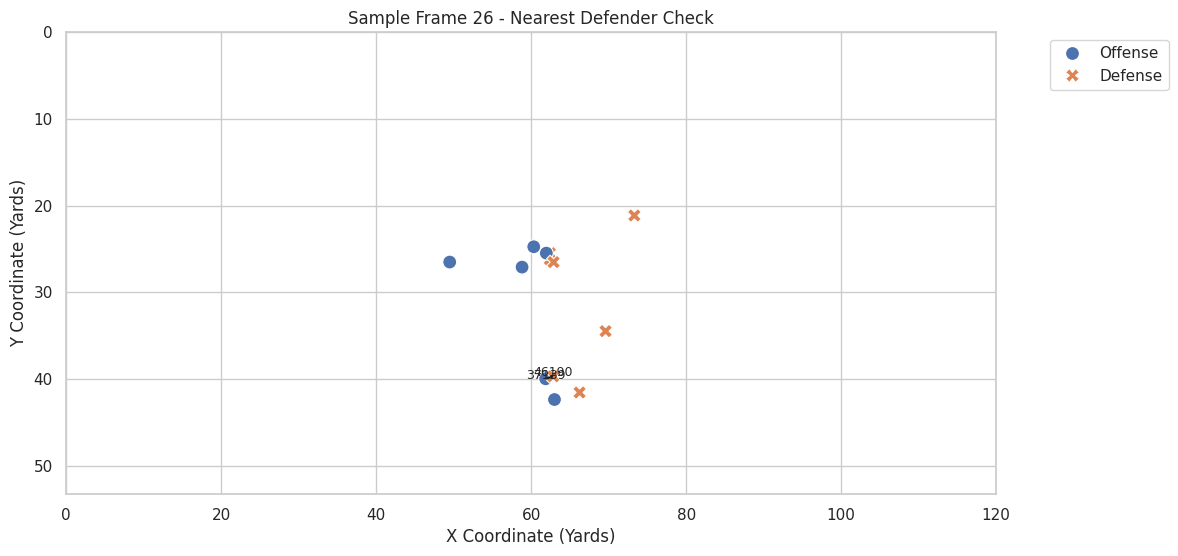


✅ Step 3 Implementation and Validation complete.


In [62]:
# Step 3 — Define neighborhoods (nearest-defender computation per frame)

# Goal: For each frame, compute nearest_defender_id, dist_to_nearest_def, and optionally k_nearest_defenders or count_within_radius.

# Strategy:
# - For each (game_id, play_id, frame_id) compute a KDTree on defenders’ (x_s, y_s) and query receiver positions. Use scipy.spatial.cKDTree for speed.

from scipy.spatial import cKDTree
import pandas as pd
import numpy as np # Import numpy for hypot
import matplotlib.pyplot as plt # Import matplotlib for plotting in validation
import seaborn as sns # Import seaborn for plotting

def compute_nearest_defenders(df_frame):
    # Ensure the group is not empty and has necessary columns
    if df_frame.empty or 'x_s' not in df_frame.columns or 'y_s' not in df_frame.columns or 'player_side' not in df_frame.columns or 'nfl_id' not in df_frame.columns:
        return pd.DataFrame() # Return empty DataFrame for invalid groups

    # Store grouping keys for this frame
    # Assuming all rows in df_frame belong to the same game, play, and frame
    group_keys = df_frame[['game_id', 'play_id', 'frame_id']].iloc[0].to_dict()

    rx = df_frame[df_frame['player_side']=='Offense'].copy() # Offensive players (receivers/ball carrier)
    dx = df_frame[df_frame['player_side']=='Defense'].copy() # Defensive players

    # Only proceed if there are both offensive and defensive players in the frame
    if dx.empty or rx.empty:
        # Return a DataFrame for offensive players with NaN for nearest defender info
        rx['nearest_def_dist'] = np.nan
        rx['nearest_def_idx'] = np.nan
        # Explicitly add grouping keys back
        for col, val in group_keys.items():
             rx[col] = val
        return rx[['game_id','play_id','frame_id','nfl_id','nearest_def_idx','nearest_def_dist']]

    # Build KD-Tree on defender smoothed positions
    # Ensure defender coordinates are not NaN before building the tree
    dx_valid = dx.dropna(subset=['x_s', 'y_s'])
    if dx_valid.empty:
        # If no valid defender coordinates, return offensive players with NaN
        rx['nearest_def_dist'] = np.nan
        rx['nearest_def_idx'] = np.nan
        # Explicitly add grouping keys back
        for col, val in group_keys.items():
             rx[col] = val
        return rx[['game_id','play_id','frame_id','nfl_id','nearest_def_idx','nearest_def_dist']]

    tree = cKDTree(dx_valid[['x_s','y_s']].values)

    # Query for nearest defender (k=1) for offensive player smoothed positions
    # Ensure offensive player coordinates are not NaN before querying
    rx_valid = rx.dropna(subset=['x_s', 'y_s'])
    if rx_valid.empty:
        return pd.DataFrame() # Return empty DataFrame if no valid offensive players

    # Perform the query
    dists, idxs = tree.query(rx_valid[['x_s','y_s']].values, k=1)

    # Map back the results to the original offensive players DataFrame
    # Initialize columns to NaN for all offensive players in the frame
    rx['nearest_def_dist'] = np.nan
    rx['nearest_def_idx'] = np.nan

    # Assign the calculated distances and defender IDs for valid offensive players
    # Need to map the indices from dx_valid back to the original dx DataFrame
    # Use the index of dx_valid to select from the nfl_id of dx
    nearest_def_nfl_ids = dx_valid.iloc[idxs]['nfl_id'].values

    # Assign the results to the original rx DataFrame based on the index of rx_valid
    rx.loc[rx_valid.index, 'nearest_def_dist'] = dists
    rx.loc[rx_valid.index, 'nearest_def_idx'] = nearest_def_nfl_ids

    # Explicitly add grouping keys back
    for col, val in group_keys.items():
         rx[col] = val

    # Return relevant columns for offensive players, including grouping keys
    return rx[['game_id','play_id','frame_id','nfl_id','nearest_def_idx','nearest_def_dist']]


# Apply the nearest defender computation frame by frame using manual iteration
# Use the smoothed dataframe from Step 2 (df_smoothed)
# Ensure df_smoothed is not empty before processing
if not df_smoothed.empty:
    nearest_features_list = []
    # Get unique frames (game_id, play_id, frame_id)
    frame_keys = df_smoothed[['game_id', 'play_id', 'frame_id']].drop_duplicates().values.tolist()

    for key in frame_keys:
        game_id, play_id, frame_id = key
        # Select the frame data
        frame_data = df_smoothed[(df_smoothed['game_id'] == game_id) & (df_smoothed['play_id'] == play_id) & (df_smoothed['frame_id'] == frame_id)].copy()

        # Compute nearest defenders for this frame
        frame_nearest_features = compute_nearest_defenders(frame_data)

        # Append the results if not empty
        if not frame_nearest_features.empty:
            nearest_features_list.append(frame_nearest_features)

    # Concatenate all frame results into a single DataFrame
    if nearest_features_list:
        nearest_defender_features = pd.concat(nearest_features_list, ignore_index=True, sort=False)
    else:
        nearest_defender_features = pd.DataFrame() # Create empty DataFrame if no features were computed


    # Merge the nearest defender features back into the main smoothed DataFrame
    # Need to merge based on game_id, play_id, frame_id, and the offensive player's nfl_id
    # The nearest_defender_features dataframe contains one row per offensive player per frame
    df_smoothed_with_neighbors = df_smoothed.merge(
        nearest_defender_features,
        on=['game_id','play_id','frame_id','nfl_id'],
        how='left' # Use left merge to keep all rows from df_smoothed
    )

else:
    df_smoothed_with_neighbors = pd.DataFrame() # Create an empty DataFrame if df_smoothed is empty
    nearest_defender_features = pd.DataFrame() # Also ensure this is defined


# Validation Steps for Step 3:

print("\nValidation for Step 3: Define neighborhoods")

# Validation 1: Check shape and columns of the nearest_defender_features table (before merging)
print("Validation 1: Shape and columns of the nearest defender features table.")
if not nearest_defender_features.empty:
    print("Shape:", nearest_defender_features.shape)
    print("Columns:", nearest_defender_features.columns.tolist())
    print("Head:")
    display(nearest_defender_features.head())
else:
    print("nearest_defender_features DataFrame is empty.")


# Validation 2: Check shape and new columns in the merged DataFrame
print("\nValidation 2: Shape and new columns in the merged DataFrame.")
if not df_smoothed_with_neighbors.empty:
    print("Shape:", df_smoothed_with_neighbors.shape)
    new_cols = ['nearest_def_idx', 'nearest_def_dist']
    print("New columns added:", [col for col in new_cols if col in df_smoothed_with_neighbors.columns])
    print("Sample rows with new columns:")
    display(df_smoothed_with_neighbors.dropna(subset=new_cols).head()) # Display rows where nearest defender was found
else:
     print("df_smoothed_with_neighbors DataFrame is empty.")


# Validation 3: Spot check a sample frame with visualization (if possible)
print("\nValidation 3: Spot check a sample frame with visualization.")
# This validation requires plotting on a field, which is manual inspection.
# We will select a sample frame and print the data for a receiver and their nearest defender.

if not df_smoothed_with_neighbors.empty and all(col in df_smoothed_with_neighbors.columns for col in ['game_id', 'play_id', 'frame_id', 'nfl_id', 'player_side', 'x_s', 'y_s', 'nearest_def_idx', 'nearest_def_dist']):
    # Select a random frame from a play that has offensive players with a nearest defender found
    sample_frame = df_smoothed_with_neighbors[(df_smoothed_with_neighbors['player_side'] == 'Offense') & (df_smoothed_with_neighbors['nearest_def_idx'].notna())].sample(1, random_state=RANDOM_STATE)

    if not sample_frame.empty:
        sample_game_id = sample_frame['game_id'].iloc[0]
        sample_play_id = sample_frame['play_id'].iloc[0]
        sample_frame_id = sample_frame['frame_id'].iloc[0]
        sample_receiver_id = sample_frame['nfl_id'].iloc[0]
        sample_nearest_def_id = sample_frame['nearest_def_idx'].iloc[0]
        sample_dist = sample_frame['nearest_def_dist'].iloc[0]

        print(f"\nSample Play: {sample_game_id}-{sample_play_id}, Frame: {sample_frame_id}")
        print(f"Receiver NFL ID: {sample_receiver_id}, Nearest Defender NFL ID: {int(sample_nearest_def_id)}, Distance: {sample_dist:.2f} yards")

        # Print positions for the receiver and their nearest defender in this frame
        sample_frame_data = df_smoothed_with_neighbors[(df_smoothed_with_neighbors['game_id'] == sample_game_id) & (df_smoothed_with_neighbors['play_id'] == sample_play_id) & (df_smoothed_with_neighbors['frame_id'] == sample_frame_id)].copy()
        receiver_pos = sample_frame_data[sample_frame_data['nfl_id'] == sample_receiver_id][['x_s', 'y_s']].iloc[0]
        defender_pos = sample_frame_data[sample_frame_data['nfl_id'] == sample_nearest_def_id][['x_s', 'y_s']].iloc[0]

        print(f"  Receiver Pos (x_s, y_s): ({receiver_pos['x_s']:.2f}, {receiver_pos['y_s']:.2f})")
        print(f"  Nearest Defender Pos (x_s, y_s): ({defender_pos['x_s']:.2f}, {defender_pos['y_s']:.2f})")

        # Optional: Simple plot for this sample frame for manual check
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=sample_frame_data, x='x_s', y='y_s', hue='player_side', style='player_side', s=100)
        plt.plot([receiver_pos['x_s'], defender_pos['x_s']], [receiver_pos['y_s'], defender_pos['y_s']], 'k--') # Line between receiver and nearest defender
        plt.text(receiver_pos['x_s'], receiver_pos['y_s'], str(sample_receiver_id), fontsize=9, ha='center')
        plt.text(defender_pos['x_s'], defender_pos['y_s'], str(int(sample_nearest_def_id)), fontsize=9, ha='center')
        plt.title(f"Sample Frame {sample_frame_id} - Nearest Defender Check")
        plt.xlabel("X Coordinate (Yards)")
        plt.ylabel("Y Coordinate (Yards)")
        plt.xlim(0, 120)
        plt.ylim(0, 53.3)
        plt.gca().invert_yaxis()
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.show()

    else:
        print("Could not find a sample frame with offensive players and nearest defenders found.")

else:
    print("Validation 3 skipped: df_smoothed_with_neighbors is empty or missing essential columns.")


print("\n✅ Step 3 Implementation and Validation complete.")

Streaming output truncated to the last 5000 lines.
  combined_mask[combined_mask] = valid_dist_mask # Apply valid_dist_mask only to the frames already selected
/tmp/ipython-input-2636332781.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[True True True True True True True True True True True]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  combined_mask[combined_mask] = valid_dist_mask # Apply valid_dist_mask only to the frames already selected
/tmp/ipython-input-2636332781.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[True True True True True True True True True True]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  combined_mask[combined_mask] = valid_dist_mask # Apply valid_dist_mask only to the frames already selected
/tmp/ip


Validation for Step 4: Compute Raw Time-Series Features
Validation 1: Plotting histograms of computed features.


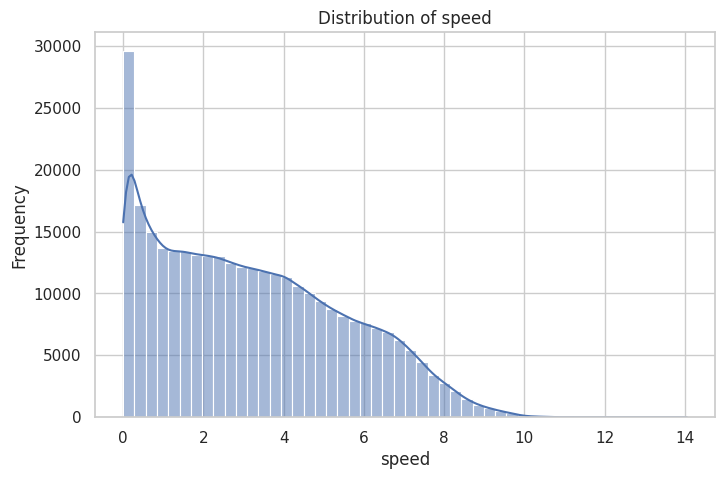

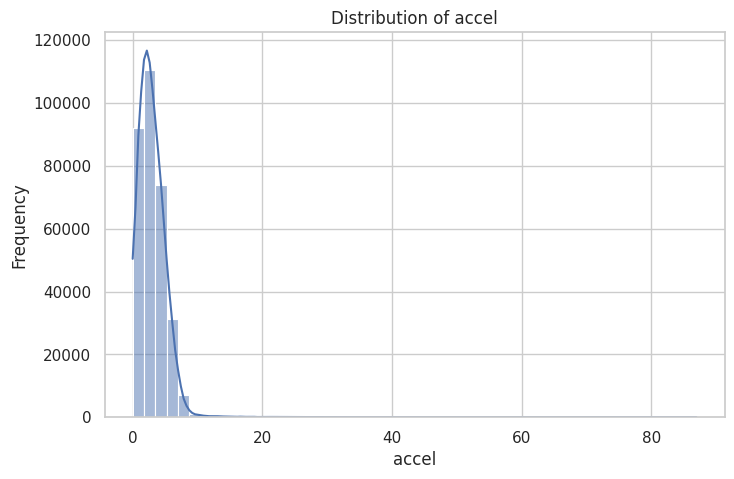

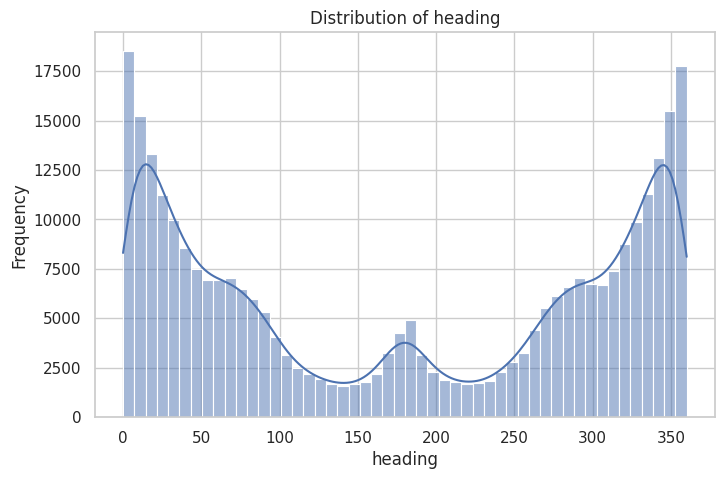

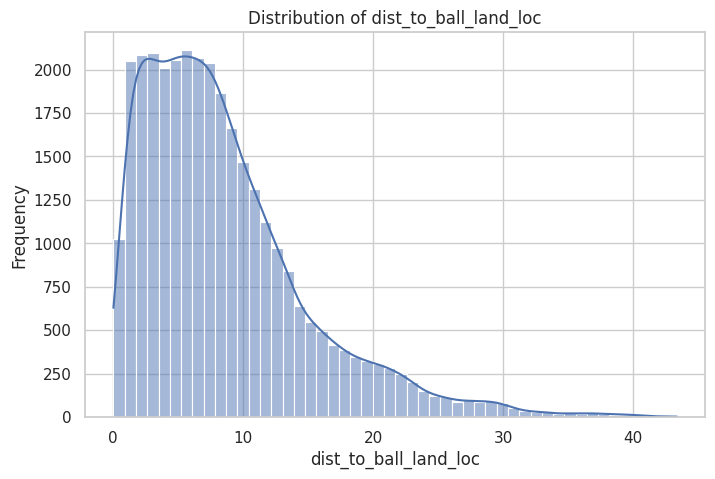

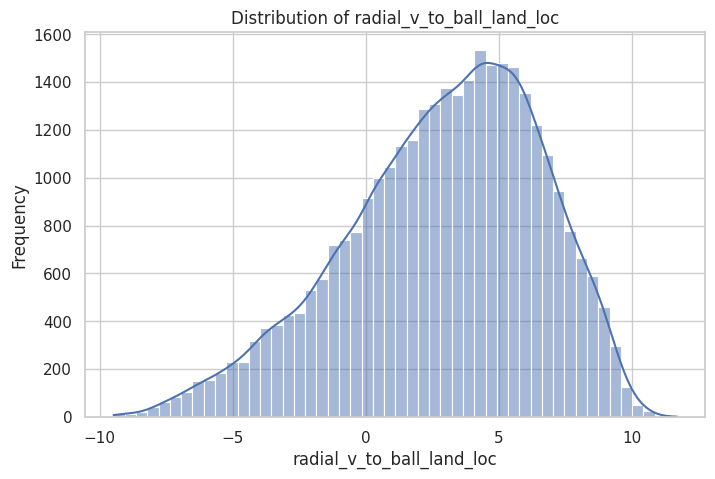


Validation 2: Sanity check on radial_v_to_ball_land_loc sign.
Sample of radial velocity values during ball flight:


,game_id,play_id,frame_id,nfl_id,radial_v_to_ball_land_loc,speed
281132,2023091012,3093,49,38577,4.392379,4.894723
259925,2023091011,3683,92,47834,0.287045,8.194693
236471,2023091010,3890,34,53465,-4.677483,8.197347
205810,2023091009,1802,31,44927,5.780546,5.953754
225579,2023091010,1810,24,53476,-5.417008,5.442492
261698,2023091011,3976,34,44862,5.197346,5.390638
12313,2023090700,2186,19,46137,-3.243115,4.578909
58152,2023091002,819,48,46104,-5.440556,8.590997
81256,2023091003,1841,44,53703,-1.112447,2.476789
129005,2023091005,3067,34,39973,-4.327705,6.397147



To manually validate: For players moving towards the ball landing location, radial_v should typically be positive. For players moving away, it should be negative.

Details for sample frame 2023091012-3093-49, Player 38577:
  Position (x_s, y_s): (76.63, 19.82)
  Velocity (v_x, v_y): (4.18, 2.55)
  Ball Landing (x, y): (78.14, 22.20)
  Radial Velocity: 4.39
  Speed: 4.89

✅ Step 4 Implementation and Validation complete.


In [64]:
# Step 4 — Compute Raw Time-Series Features

# Goal: Compute velocity, speed, acceleration, heading, distance to ball landing, and radial velocity.

# Strategy:
# - Compute derivatives using finite differences on smoothed x_s and y_s.
# - Calculations are per player-play.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Constants (already defined, redefining for clarity in this cell)
DT = 1.0 / 10 # Assuming FRAME_RATE is 10

def compute_motion_features(g):
    # Ensure the group is not empty and has necessary columns
    if g.empty or 'x_s' not in g.columns or 'y_s' not in g.columns or 'frame_id' not in g.columns:
        return pd.DataFrame() # Return empty DataFrame for invalid groups

    # Ensure the group is sorted by frame_id for correct diff calculation
    g = g.sort_values('frame_id').copy()


    # Velocity
    g['v_x'] = g['x_s'].diff().fillna(0) / DT
    g['v_y'] = g['y_s'].diff().fillna(0) / DT
    g['speed'] = np.hypot(g['v_x'], g['v_y'])

    # Acceleration
    g['a_x'] = g['v_x'].diff().fillna(0) / DT
    g['a_y'] = g['v_y'].diff().fillna(0) / DT
    g['accel'] = np.hypot(g['a_x'], g['a_y'])

    # Heading (radians first, then degrees 0-360)
    # Use arctan2 which handles quadrants correctly
    g['heading_rad'] = np.arctan2(g['v_y'], g['v_x'])
    g['heading'] = np.degrees(g['heading_rad'])
    g['heading'] = (g['heading'] + 360) % 360 # Normalize to 0-360

    # Handle heading for zero speed - set to NaN or previous heading?
    # For simplicity and consistency with some approaches, let's set heading to NaN if speed is effectively zero
    g.loc[g['speed'] < 1e-3, 'heading'] = np.nan # Use a small tolerance for zero speed


    # Distance to ball landing location (only during ball flight)
    # Ensure ball_land_x/y are available (merged in Step 1) and are not NaN
    g['dist_to_ball_land_loc'] = np.nan # Initialize

    # Mask for ball flight frames that also have valid ball landing coordinates
    mask_in_flight_and_valid_ball_land = (
        (g['is_in_flight'] == True) &
        (g['ball_land_x'].notna()) &
        (g['ball_land_y'].notna())
    )

    if mask_in_flight_and_valid_ball_land.any(): # Only calculate if there are frames meeting the criteria
        g.loc[mask_in_flight_and_valid_ball_land, 'dist_to_ball_land_loc'] = np.hypot(
            g.loc[mask_in_flight_and_valid_ball_land, 'x_s'] - g.loc[mask_in_flight_and_valid_ball_land, 'ball_land_x'],
            g.loc[mask_in_flight_and_valid_ball_land, 'y_s'] - g.loc[mask_in_flight_and_valid_ball_land, 'ball_land_y']
        )


    # Radial Velocity relative to Ball Landing Location (only during ball flight)
    g['radial_v_to_ball_land_loc'] = np.nan # Initialize

    if mask_in_flight_and_valid_ball_land.any(): # Only calculate if there are frames meeting the criteria
         # Vector from player to ball landing location for relevant frames
        vec_to_ball_x = g.loc[mask_in_flight_and_valid_ball_land, 'ball_land_x'] - g.loc[mask_in_flight_and_valid_ball_land, 'x_s']
        vec_to_ball_y = g.loc[mask_in_flight_and_valid_ball_land, 'ball_land_y'] - g.loc[mask_in_flight_and_valid_ball_land, 'y_s']

        # Magnitude of vector to ball landing location
        dist_to_ball = np.hypot(vec_to_ball_x, vec_to_ball_y)

        # Avoid division by zero where player is exactly at ball landing location
        valid_dist_mask = dist_to_ball > 1e-6 # Small tolerance to avoid / 0

        # Combine with the original mask for in-flight and valid ball landing
        combined_mask = mask_in_flight_and_valid_ball_land.copy()
        combined_mask[combined_mask] = valid_dist_mask # Apply valid_dist_mask only to the frames already selected

        if combined_mask.any(): # Only proceed if there are frames with non-zero distance
            # Normalized vector from player to ball landing location for valid frames
            norm_vec_to_ball_x = vec_to_ball_x[valid_dist_mask] / dist_to_ball[valid_dist_mask]
            norm_vec_to_ball_y = vec_to_ball_y[valid_dist_mask] / dist_to_ball[valid_dist_mask]

            # Player velocity vector for valid frames
            v_x_in_flight = g.loc[combined_mask, 'v_x'] # Use combined mask
            v_y_in_flight = g.loc[combined_mask, 'v_y'] # Use combined mask

            # Radial velocity = dot product of velocity and normalized vector to ball
            # Use the index from the combined_mask to assign back to the original g
            g.loc[combined_mask, 'radial_v_to_ball_land_loc'] = (
                v_x_in_flight * norm_vec_to_ball_x.values + v_y_in_flight * norm_vec_to_ball_y.values # Use .values to align
            )


    # Return the processed group with all original columns and new features
    return g

# Apply motion feature computation to each player's track by manual iteration
# Use the dataframe from Step 3 (df_smoothed_with_neighbors)
# Ensure df_smoothed_with_neighbors is not empty before processing
if not df_smoothed_with_neighbors.empty:
    feature_tracks = []
    # Get unique groups (game_id, play_id, nfl_id)
    group_keys = df_smoothed_with_neighbors[['game_id', 'play_id', 'nfl_id']].drop_duplicates().values.tolist()

    for key in group_keys:
        game_id, play_id, nfl_id = key
        # Select the group data
        group_data = df_smoothed_with_neighbors[(df_smoothed_with_neighbors['game_id'] == game_id) & (df_smoothed_with_neighbors['play_id'] == play_id) & (df_smoothed_with_neighbors['nfl_id'] == nfl_id)].copy()

        # Compute motion features for the track
        processed_group = compute_motion_features(group_data)

        # Append the processed group to the list if not empty
        if not processed_group.empty:
            feature_tracks.append(processed_group)

    # Concatenate all processed tracks into a single DataFrame
    if feature_tracks:
        df_features = pd.concat(feature_tracks, ignore_index=True, sort=False)
    else:
        df_features = pd.DataFrame() # Create an empty DataFrame if no tracks were processed

else:
    df_features = pd.DataFrame() # Create an empty DataFrame if df_smoothed_with_neighbors is empty


# Validation Steps for Step 4:

print("\nValidation for Step 4: Compute Raw Time-Series Features")

# Ensure df_features is not empty before performing validations
if not df_features.empty:

    # Validation 1: Plot histograms of new features
    print("Validation 1: Plotting histograms of computed features.")
    features_to_plot = ['speed', 'accel', 'heading', 'dist_to_ball_land_loc', 'radial_v_to_ball_land_loc']

    for feature in features_to_plot:
        if feature in df_features.columns:
            plt.figure(figsize=(8, 5))
            # Only plot non-NaN values
            sns.histplot(df_features[feature].dropna(), kde=True, bins=50)
            plt.title(f"Distribution of {feature}")
            plt.xlabel(feature)
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.show()
        else:
            print(f"Feature '{feature}' not found in df_features.")


    # Validation 2: Sanity check on radial_v_to_ball_land_loc sign.
    print("\nValidation 2: Sanity check on radial_v_to_ball_land_loc sign.")

    # Select a few random frames during ball flight where radial_v is not NaN
    sample_radial_frames = df_features[(df_features['is_in_flight'] == True) & (df_features['radial_v_to_ball_land_loc'].notna())].sample(min(10, df_features[(df_features['is_in_flight'] == True) & (df_features['radial_v_to_ball_land_loc'].notna())].shape[0]), random_state=RANDOM_STATE)

    if not sample_radial_frames.empty:
        print("Sample of radial velocity values during ball flight:")
        display(sample_radial_frames[['game_id', 'play_id', 'frame_id', 'nfl_id', 'radial_v_to_ball_land_loc', 'speed']].head(10))

        print("\nTo manually validate: For players moving towards the ball landing location, radial_v should typically be positive. For players moving away, it should be negative.")
        # Optional: Select one frame and print positions and velocities for manual check
        if sample_radial_frames.shape[0] > 0:
             sample_row = sample_radial_frames.iloc[0]
             g, p, f, n = sample_row['game_id'], sample_row['play_id'], sample_row['frame_id'], sample_row['nfl_id']
             print(f"\nDetails for sample frame {g}-{p}-{f}, Player {n}:")
             player_data_in_frame = df_features[(df_features['game_id'] == g) & (df_features['play_id'] == p) & (df_features['frame_id'] == f) & (df_features['nfl_id'] == n)].iloc[0]
             print(f"  Position (x_s, y_s): ({player_data_in_frame['x_s']:.2f}, {player_data_in_frame['y_s']:.2f})")
             # Corrected the typo here
             print(f"  Velocity (v_x, v_y): ({player_data_in_frame['v_x']:.2f}, {player_data_in_frame['v_y']:.2f})")
             print(f"  Ball Landing (x, y): ({player_data_in_frame['ball_land_x']:.2f}, {player_data_in_frame['ball_land_y']:.2f})")
             print(f"  Radial Velocity: {player_data_in_frame['radial_v_to_ball_land_loc']:.2f}")
             print(f"  Speed: {player_data_in_frame['speed']:.2f}")

    else:
        print("Could not find sample frames with non-NaN radial velocity during ball flight for validation.")


else:
    print("df_features DataFrame is empty, cannot perform validations.")


print("\n✅ Step 4 Implementation and Validation complete.")


Validation for Step 5: Aggregate During Ball Flight
Validation 1: Shape and columns of the aggregated DataFrame.
Shape: (2679, 11)
Columns: ['game_id', 'play_id', 'nfl_id', 'sep_at_throw', 'sep_at_catch_end', 'sep_gain', 'avg_radial_v', 'max_radial_v', 'min_radial_v', 'path_length_in_flight', 'time_to_land_loc']
Head:


,game_id,play_id,nfl_id,sep_at_throw,sep_at_catch_end,sep_gain,avg_radial_v,max_radial_v,min_radial_v,path_length_in_flight,time_to_land_loc
0,2023090700,101,44930,4.472250,1.844679,-2.627571,7.037489,8.112139,5.745349,16.184339,2.0
1,2023090700,101,46137,NaN,NaN,NaN,6.892755,8.239046,5.044334,15.070305,2.0
2,2023090700,101,52546,NaN,NaN,NaN,3.638350,4.964701,1.451345,9.433912,2.0
3,2023090700,194,41325,1.937328,1.223082,-0.714246,2.415050,5.661093,-4.437013,5.164643,0.8
4,2023090700,194,44888,NaN,NaN,NaN,4.723468,5.365626,3.421990,4.367614,0.8



Validation 2: Plotting histograms of aggregated features.


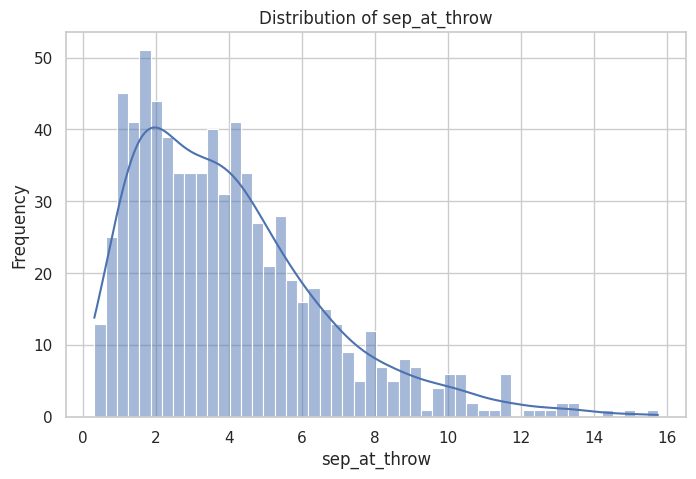

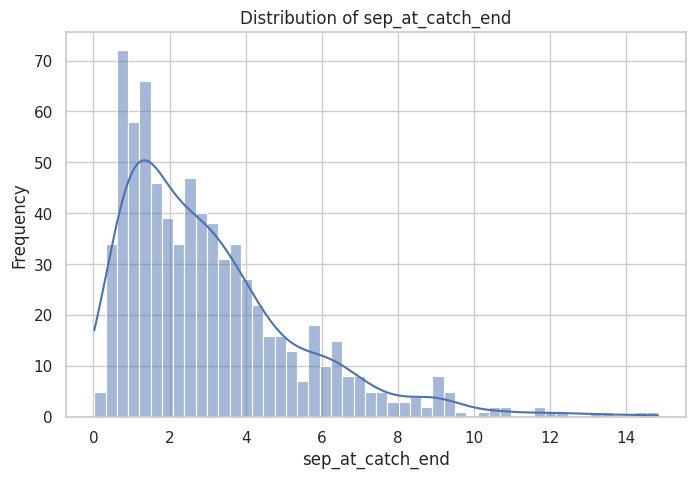

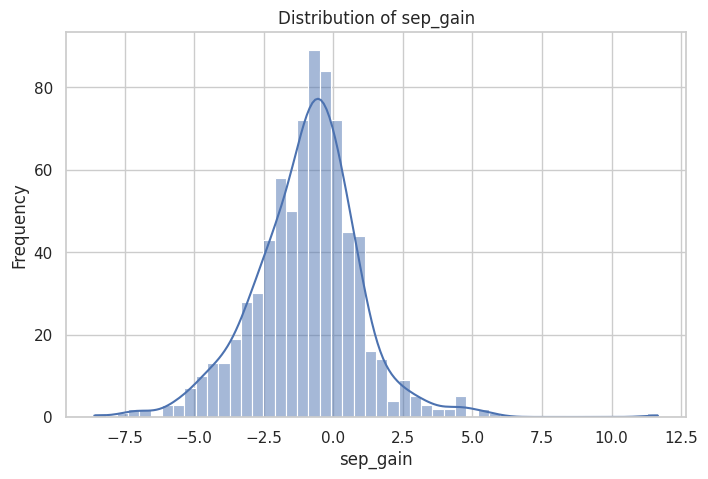

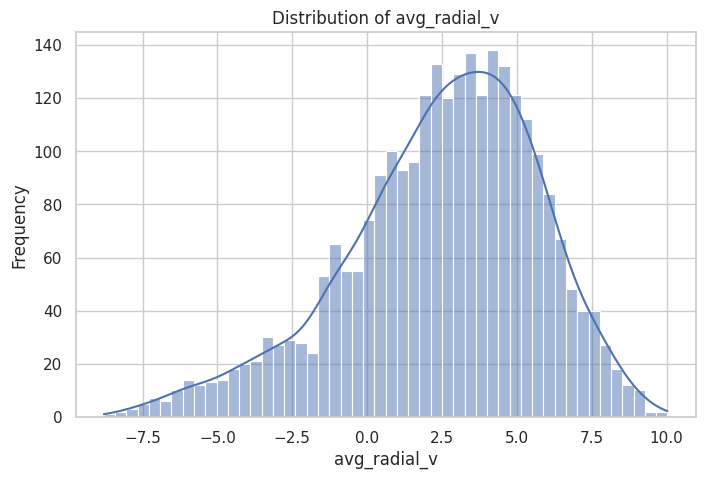

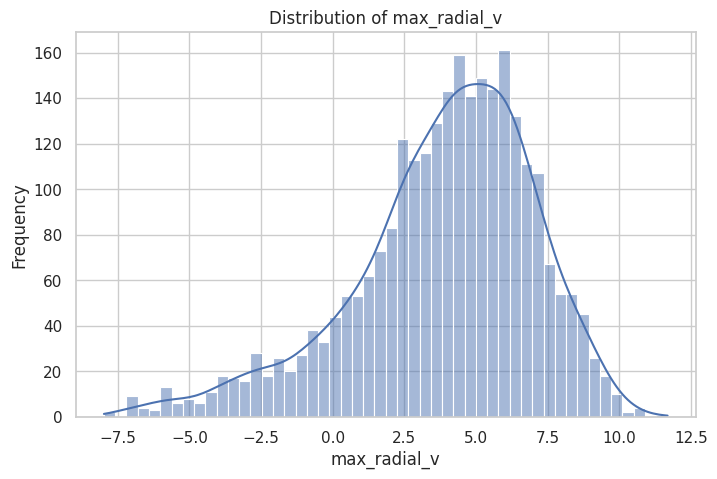

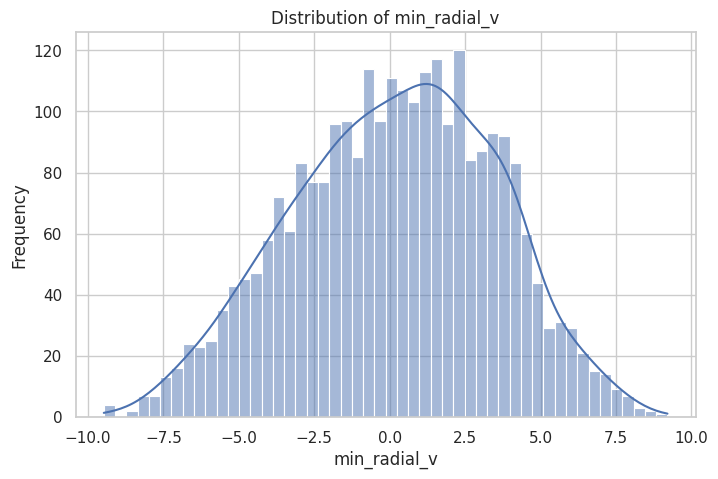

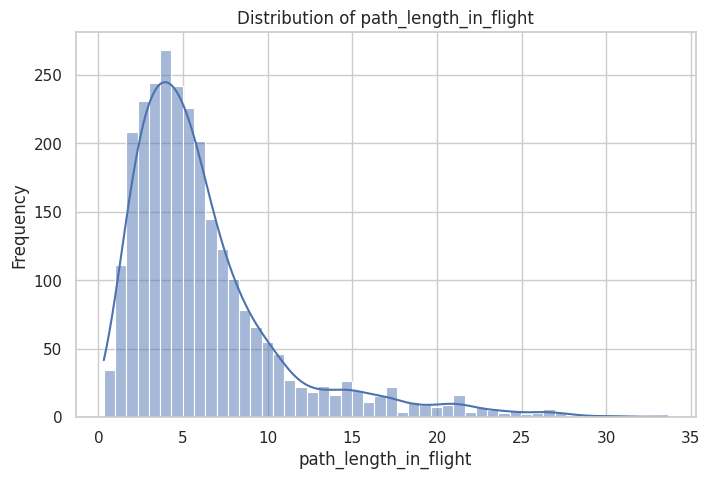

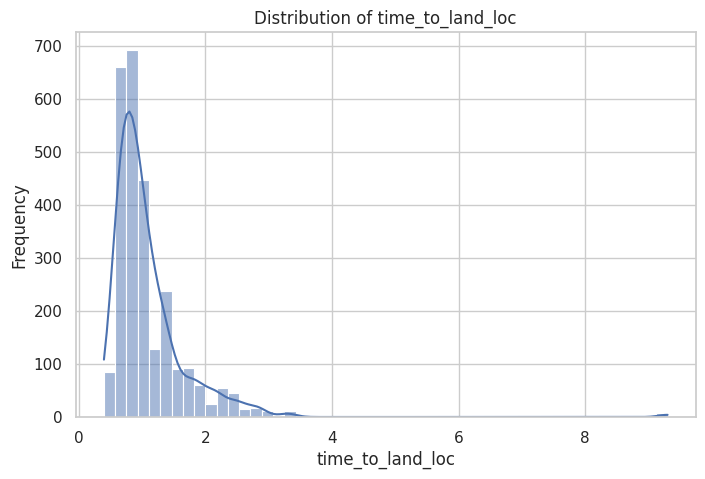


Validation 3: Sanity check relationships between aggregated features.
Correlation between Average Speed and Path Length during flight:
Pearson correlation: 0.7160


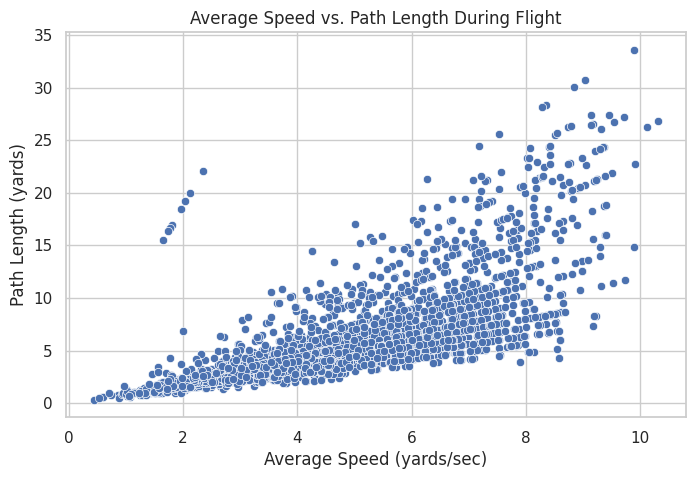


Separation Gain by Player Role:
No 'Receiver' role found in data.

✅ Step 5 Implementation and Validation complete.


In [65]:
# Step 5 — Aggregate During Ball Flight

# Goal: Collapse per-frame data during ball flight into per-player-per-play summary metrics.

# Strategy:
# - Filter for frames where is_in_flight is True.
# - Calculate specified aggregation metrics (separation at throw/catch, radial velocity stats, path length, time to land).
# - Results are one row per player-play that had ball flight data.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Constants (already defined, redefining for clarity in this cell)
DT = 1.0 / 10 # Assuming FRAME_RATE is 10

def aggregate_in_flight_features(g):
    # Ensure the group is not empty and has necessary columns
    if g.empty or 'is_in_flight' not in g.columns or 'frame_id' not in g.columns:
        return pd.DataFrame() # Return empty DataFrame for invalid groups

    # Filter for ball flight frames
    g_in_flight = g[g['is_in_flight']==True].copy()

    if g_in_flight.empty:
         return pd.DataFrame() # Return empty if no ball flight frames

    # Ensure ball flight frames are sorted by frame_id
    g_in_flight = g_in_flight.sort_values('frame_id')

    # Define the aggregation window using the first and last frames in flight
    first_frame_in_flight = g_in_flight.iloc[0]
    last_frame_in_flight = g_in_flight.iloc[-1]

    # --- Calculate Aggregation Metrics ---

    # Separation metrics
    # Ensure nearest_def_dist is available
    sep_at_throw = first_frame_in_flight['nearest_def_dist'] if 'nearest_def_dist' in first_frame_in_flight else np.nan
    sep_at_catch_end = last_frame_in_flight['nearest_def_dist'] if 'nearest_def_dist' in last_frame_in_flight else np.nan
    sep_gain = sep_at_catch_end - sep_at_throw # This will be NaN if either sep_at_throw or sep_at_catch_end is NaN

    # Radial Velocity aggregation (handle NaNs in radial_v_to_ball_land_loc)
    # Ensure radial_v_to_ball_land_loc is available
    if 'radial_v_to_ball_land_loc' in g_in_flight.columns:
        avg_radial_v = g_in_flight['radial_v_to_ball_land_loc'].mean()
        max_radial_v = g_in_flight['radial_v_to_ball_land_loc'].max() # Max can be negative
        min_radial_v = g_in_flight['radial_v_to_ball_land_loc'].min() # Min can be positive
    else:
        avg_radial_v = np.nan
        max_radial_v = np.nan
        min_radial_v = np.nan


    # Path Length aggregation (sum speed * DT)
    # Ensure speed is available
    path_length_in_flight = (g_in_flight['speed'] * DT).sum() if 'speed' in g_in_flight.columns else np.nan


    # Time to Ball Landing Location
    time_to_land_loc = last_frame_in_flight['time_from_throw'] - first_frame_in_flight['time_from_throw'] if 'time_from_throw' in g_in_flight.columns else np.nan

    # --- Create Output Row ---
    # Ensure grouping columns are present
    if 'game_id' not in g.columns or 'play_id' not in g.columns or 'nfl_id' not in g.columns:
         return pd.DataFrame() # Cannot create result row without grouping keys

    result = {
        'game_id': g['game_id'].iloc[0],
        'play_id': g['play_id'].iloc[0],
        'nfl_id': g['nfl_id'].iloc[0],
        'sep_at_throw': sep_at_throw,
        'sep_at_catch_end': sep_at_catch_end,
        'sep_gain': sep_gain,
        'avg_radial_v': avg_radial_v,
        'max_radial_v': max_radial_v,
        'min_radial_v': min_radial_v, # Added min_radial_v for more context
        'path_length_in_flight': path_length_in_flight,
        'time_to_land_loc': time_to_land_loc
    }

    # Return as DataFrame (one row per player-play with ball flight data)
    return pd.DataFrame([result])

# Apply aggregation to each player's track during ball flight by manual iteration
# Use the dataframe from Step 4 (df_features)
# Ensure df_features is not empty before processing
if not df_features.empty:
    aggregated_features_list = []
    # Get unique groups (game_id, play_id, nfl_id)
    group_keys = df_features[['game_id', 'play_id', 'nfl_id']].drop_duplicates().values.tolist()

    for key in group_keys:
        game_id, play_id, nfl_id = key
        # Select the group data
        group_data = df_features[(df_features['game_id'] == game_id) & (df_features['play_id'] == play_id) & (df_features['nfl_id'] == nfl_id)].copy()

        # Aggregate features for the track
        aggregated_group = aggregate_in_flight_features(group_data)

        # Append the aggregated group to the list if not empty
        if not aggregated_group.empty:
            aggregated_features_list.append(aggregated_group)

    # Concatenate all aggregated results into a single DataFrame
    if aggregated_features_list:
        df_aggregated = pd.concat(aggregated_features_list, ignore_index=True, sort=False)
    else:
        df_aggregated = pd.DataFrame() # Create an empty DataFrame if no features were aggregated

else:
    df_aggregated = pd.DataFrame() # Create an empty DataFrame if df_features is empty


# Validation Steps for Step 5:

print("\nValidation for Step 5: Aggregate During Ball Flight")

# Ensure df_aggregated is not empty before performing validations
if not df_aggregated.empty:

    # Validation 1: Check shape and columns of the aggregated DataFrame
    print("Validation 1: Shape and columns of the aggregated DataFrame.")
    print("Shape:", df_aggregated.shape)
    print("Columns:", df_aggregated.columns.tolist())
    print("Head:")
    display(df_aggregated.head())


    # Validation 2: Plot histograms of aggregated features
    print("\nValidation 2: Plotting histograms of aggregated features.")
    aggregated_features_to_plot = ['sep_at_throw', 'sep_at_catch_end', 'sep_gain', 'avg_radial_v', 'max_radial_v', 'min_radial_v', 'path_length_in_flight', 'time_to_land_loc']

    for feature in aggregated_features_to_plot:
        if feature in df_aggregated.columns:
            plt.figure(figsize=(8, 5))
            # Only plot non-NaN values
            sns.histplot(df_aggregated[feature].dropna(), kde=True, bins=50)
            plt.title(f"Distribution of {feature}")
            plt.xlabel(feature)
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.show()
        else:
            print(f"Aggregated feature '{feature}' not found in df_aggregated.")

    # Validation 3: Sanity check relationships (e.g., speed vs. path length, receiver separation)
    print("\nValidation 3: Sanity check relationships between aggregated features.")

    # Example 1: Speed vs Path Length
    # Path length is sum(speed * DT), so they should be strongly correlated.
    if 'speed' in df_features.columns and 'path_length_in_flight' in df_aggregated.columns:
        # Need to merge avg speed during flight back to df_aggregated for comparison
        avg_speed_in_flight = df_features[df_features['is_in_flight'] == True].groupby(['game_id', 'play_id', 'nfl_id'])['speed'].mean().reset_index(name='avg_speed_in_flight')
        compare_df = df_aggregated.merge(avg_speed_in_flight, on=['game_id', 'play_id', 'nfl_id'], how='left')

        if not compare_df.empty and 'avg_speed_in_flight' in compare_df.columns:
            print("Correlation between Average Speed and Path Length during flight:")
            # Compute correlation only on non-NaN values
            correlation = compare_df[['avg_speed_in_flight', 'path_length_in_flight']].corr().iloc[0, 1]
            print(f"Pearson correlation: {correlation:.4f}")

            # Optional: Scatter plot
            plt.figure(figsize=(8, 5))
            sns.scatterplot(data=compare_df.dropna(subset=['avg_speed_in_flight', 'path_length_in_flight']), x='avg_speed_in_flight', y='path_length_in_flight')
            plt.title("Average Speed vs. Path Length During Flight")
            plt.xlabel("Average Speed (yards/sec)")
            plt.ylabel("Path Length (yards)")
            plt.grid(True)
            plt.show()
        else:
            print("Could not perform Speed vs Path Length correlation check.")
    else:
        print("Speed or Path Length columns not found for correlation check.")

    # Example 2: Separation Gain for Receivers vs Others
    # This requires player role information (merged in earlier steps)
    if 'player_role' in df_features.columns and 'sep_gain' in df_aggregated.columns:
         # Merge player role into df_aggregated
         player_roles = df_features[['game_id', 'play_id', 'nfl_id', 'player_role']].drop_duplicates()
         compare_df_roles = df_aggregated.merge(player_roles, on=['game_id', 'play_id', 'nfl_id'], how='left')

         if not compare_df_roles.empty and 'player_role' in compare_df_roles.columns and 'sep_gain' in compare_df_roles.columns:
             print("\nSeparation Gain by Player Role:")
             # Ensure 'Receiver' role exists before grouping
             if 'Receiver' in compare_df_roles['player_role'].unique():
                 display(compare_df_roles.groupby('player_role')['sep_gain'].describe())
             else:
                 print("No 'Receiver' role found in data.")
         else:
              print("Could not perform Separation Gain by Player Role check.")
    else:
        print("Player Role or Separation Gain columns not found for check.")


else:
    print("df_aggregated DataFrame is empty, cannot perform validations.")

print("\n✅ Step 5 Implementation and Validation complete.")

In [69]:
# Save the final aggregated data to a parquet file

import pandas as pd
from pathlib import Path
import os

# Define the output directory to the main content directory
# Using Path('/content/') for easier access in Colab file browser
OUTDIR = Path('/content/')
OUTDIR.mkdir(parents=True, exist_ok=True) # Ensure the directory exists (though /content/ usually exists)

# Define the output file path directly in the content directory
out_file = OUTDIR / 'aggregated_week01.parquet'

# Check if df_aggregated DataFrame exists and is not empty before saving
if 'df_aggregated' in locals() and not df_aggregated.empty:
    try:
        # Save the DataFrame to a parquet file
        df_aggregated.to_parquet(out_file, index=False, compression='snappy')
        print(f"Successfully saved df_aggregated to {out_file}")

        # Optional: Quick load back verification
        df_check_save = pd.read_parquet(out_file)
        if len(df_check_save) == len(df_aggregated):
            print("Load-back verification successful.")
        else:
            print("Load-back verification failed: Row count mismatch.")

    except Exception as e:
        print(f"An error occurred while saving the parquet file: {e}")

else:
    print("df_aggregated DataFrame is not available or is empty. Skipping save.")

Successfully saved df_aggregated to /content/aggregated_week01.parquet
Load-back verification successful.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [67]:
# Load the aggregated data from the parquet file

import pandas as pd
from pathlib import Path

# Define the output directory (assuming OUTDIR is defined from Step 0)
# Redefining OUTDIR here for clarity and robustness if previous cells were not run
OUTDIR = Path('data/interim')

# Define the file path
in_file = OUTDIR / 'aggregated_week01.parquet'

# Check if the file exists before attempting to load
if in_file.exists():
    try:
        # Load the DataFrame from the parquet file
        df_loaded_aggregated = pd.read_parquet(in_file)

        # Display the head of the loaded DataFrame
        print(f"Successfully loaded data from {in_file}")
        print("Head of the loaded DataFrame:")
        display(df_loaded_aggregated.head())

    except Exception as e:
        print(f"An error occurred while loading the parquet file: {e}")

else:
    print(f"File not found at {in_file}. Please ensure the file was saved correctly.")

Successfully loaded data from data/interim/aggregated_week01.parquet
Head of the loaded DataFrame:


,game_id,play_id,nfl_id,sep_at_throw,sep_at_catch_end,sep_gain,avg_radial_v,max_radial_v,min_radial_v,path_length_in_flight,time_to_land_loc
0,2023090700,101,44930,4.472250,1.844679,-2.627571,7.037489,8.112139,5.745349,16.184339,2.0
1,2023090700,101,46137,NaN,NaN,NaN,6.892755,8.239046,5.044334,15.070305,2.0
2,2023090700,101,52546,NaN,NaN,NaN,3.638350,4.964701,1.451345,9.433912,2.0
3,2023090700,194,41325,1.937328,1.223082,-0.714246,2.415050,5.661093,-4.437013,5.164643,0.8
4,2023090700,194,44888,NaN,NaN,NaN,4.723468,5.365626,3.421990,4.367614,0.8


# Data processing steps you must  implement

# Step 1 — Synchronize events (align throw → tracking timestamps)

### Goal

Mark the frame that corresponds to ball release and the end/catch frame for each play so later features use exactly the ball-in-air window.

### How this dataset defines it (practical)

- The first row(s) in the **output** file have `frame_id == 1` for that `(game_id, play_id, nfl_id)` — that is the first frame **after the throw** (i.e., throw moment is the transition from input → output).
- `num_frames_output` from the input tells how many output frames exist; so `frame_id == num_frames_output` corresponds to ball landing (catch/incomplete) frame.

### Implementation

1. Create a per-play table (one row per `(game_id, play_id)`) with:
    - `throw_frame = 1` (relative to output frames)
    - `catch_frame = num_frames_output` (from input merged into df)
    - `start_time = 0.0` (relative) and `end_time = (num_frames_output - 1) * DT`
    - `ball_land_x`, `ball_land_y`, `pass_result` from input/supplementary.
2. Add columns to `df` (per-frame):
    
    ```python
    df['time_from_throw'] = (df['frame_id'] - 1) * DT
    df['is_in_flight'] = True  # all rows in output are during flight
    
    ```
    
3. If you have multiple output files, ensure `frame_id` restarts at 1 per `(game_id, play_id, nfl_id)`, else rescale.

### Validation

- For a sample of plays, confirm `max(frame_id)` equals `num_frames_output`.
- Plot `time_from_throw` histogram — distribution should look reasonable (most plays 1–3 seconds).

# Step 2 — Smoothing & interpolation (Kalman / low-pass / Savitzky–Golay)

### Goal

Remove jitter and fix small missing frames so derivatives (speed, accel, heading) are stable.

### Strategy / defaults

1. **Reindex & linear interpolate missing frames** per player up to small gaps (≤ 3 consecutive frames). If a player is missing > 30% frames or entire track missing, flag/exclude.
2. **Outlier/jump detection**: mark frames where frame-to-frame distance > `JUMP_THRESH` (default = 5 yards per 0.1 s) and treat as NaN to be interpolated.
3. **Smoothing**: apply **Savitzky–Golay** on `x` and `y` (window=5, polyorder=2). Optionally for troublesome plays apply **Kalman Filter** (FilterPy) with constant-velocity model.

### Pseudocode (pandas)

```python
from scipy.signal import savgol_filter
import numpy as np

DT = 0.1
JUMP_THRESH = 5.0  # yards per frame (tunable)
SG_WINDOW = 5
SG_POLY = 2

def process_player_track(g):
    # reindex
    n = int(g['num_frames_output'].iloc[0])
    idx = pd.DataFrame({'frame_id': range(1, n+1)})
    g = idx.merge(g, on='frame_id', how='left')
    # interpolate small NaNs linearly
    g[['x','y']] = g[['x','y']].interpolate(method='linear', limit=3, limit_direction='both')
    # detect huge jumps: mark as NaN then interpolate
    dx = g['x'].diff().fillna(0)
    dy = g['y'].diff().fillna(0)
    jump = np.hypot(dx, dy) > JUMP_THRESH
    g.loc[jump, ['x','y']] = np.nan
    g[['x','y']] = g[['x','y']].interpolate(method='linear', limit_direction='both')
    # apply Savitzky-Golay smoothing
    L = len(g)
    w = min(SG_WINDOW, L if L%2==1 else L-1)
    if w >= 3:
        g['x_s'] = savgol_filter(g['x'].values, w, SG_POLY)
        g['y_s'] = savgol_filter(g['y'].values, w, SG_POLY)
    else:
        g['x_s'] = g['x']; g['y_s'] = g['y']
    return g

```

### Kalman filter (optional)

- Use a constant-velocity 4D state `[x, y, vx, vy]`. Initialize from first two frames. Tune process noise and measurement noise by inspecting residuals.
- Filter is more robust for longer occlusions.

### Validation

- Plot sample raw vs smoothed `x` & `y`.
- Compute speed pre- and post-smoothing — expect fewer spikes (clip unrealistically high speeds).
- Report percent frames interpolated per play; flag plays with >5% interpolation.

# Step 3 — Define neighborhoods (nearest-defender computation per frame)

### Goal

For each frame, compute `nearest_defender_id`, `dist_to_nearest_def`, and optionally `k_nearest_defenders` or `count_within_radius`.

### Strategy

- For each `(game_id, play_id, frame_id)` compute a KDTree on defenders’ `(x_s, y_s)` and query receiver positions. Use `scipy.spatial.cKDTree` for speed.

### Pseudocode

```python
from scipy.spatial import cKDTree

def compute_nearest_defenders(df_frame):
    # df_frame has rows for all players in that frame
    rx = df_frame[df_frame['player_side']=='Offense']
    dx = df_frame[df_frame['player_side']=='Defense']
    if dx.empty or rx.empty:
        return []
    tree = cKDTree(dx[['x_s','y_s']].values)
    dists, idxs = tree.query(rx[['x_s','y_s']].values, k=1)
    # map back
    rx = rx.copy()
    rx['nearest_def_dist'] = dists
    rx['nearest_def_idx'] = dx.iloc[idxs]['nfl_id'].values
    return rx[['game_id','play_id','frame_id','nfl_id','nearest_def_idx','nearest_def_dist']]

```

### Additional derived features

- `n_def_within_R` where `R = 3.0` yards — defenders able to contest: query `tree.query_ball_point`.
- `k_nearest` distances (k=3) for density measures.

### Validation

- For sample frames, print receiver with nearest defender id & distance, visualize on field to confirm.


Perfect — this is one of the *most sensitive* steps in your entire pipeline, because **everything that follows (like separation gain, reaction speed, etc.) depends on these raw features being clean and consistent**.

Let’s turn this into a **detailed, mistake-proof Step 4 implementation guide** — precise, ordered, and validated at every stage.

---

# ⚙️ Step 4 — Compute Raw Time-Series Features

### *(Separation(t), Speed(t), Accel(t), Heading(t), Radial v)*

---

## 🎯 **Purpose**

To derive clean, physically meaningful **per-frame motion features** that describe how each player moves and relates to the ball’s eventual landing point.

You’ll go from positional coordinates (`x`, `y`) → time-series dynamics:
`speed`, `acceleration`, `heading`, `distance_to_ball_land`, and `radial_velocity`.

---

## 🧩 **Implementation Plan**

### 1️⃣ Start from the right dataframe

Use the fully reconstructed dataset from Step 3 (continuous `frame_id`, both pre- and post-throw frames).

```python
import numpy as np
import pandas as pd

df = reconstructed_df.copy()
```

Each record should have:
`game_id, play_id, nfl_id, frame_id, x, y, ball_land_x, ball_land_y`.

---

### 2️⃣ Sort and group

Each player’s movement must be processed chronologically.

```python
df = df.sort_values(['game_id','play_id','nfl_id','frame_id'])
```

Then process group-wise:

```python
def compute_motion_features(g):
    g = g.copy()
```

---

### 3️⃣ Compute motion deltas (frame-to-frame)

Frame rate = 10 Hz → Δt = 0.1 s.

```python
    dx = g['x'].diff()
    dy = g['y'].diff()
    dt = 0.1  # seconds per frame
```

---

### 4️⃣ Instantaneous speed `s` and acceleration `a`

```python
    g['speed'] = np.hypot(dx, dy) / dt
    g['accel'] = g['speed'].diff() / dt
```

💡 *Interpretation*:

* `speed` = yards per second
* `accel` = yards per second²
* First frame per player will have NaN → fill with 0.

---

### 5️⃣ Heading (direction of movement)

```python
    g['heading'] = np.arctan2(dy, dx)  # radians
```

Optionally convert to degrees:

```python
    # g['heading_deg'] = np.degrees(g['heading'])
```

---

### 6️⃣ Distance to the ball’s landing spot

At each frame:

```python
    g['dist_to_land'] = np.hypot(
        g['ball_land_x'] - g['x'],
        g['ball_land_y'] - g['y']
    )
```

This shows how far a player is from the ball’s expected impact point.

---

### 7️⃣ Radial velocity (`v_radial`)

This is the **component of a player’s velocity vector toward/away from the ball**.

Steps:

1. Compute instantaneous velocity components:
   `vx = dx/dt`, `vy = dy/dt`
2. Compute **unit vector** pointing from player → ball landing:

   ```python
   ux = (g['ball_land_x'] - g['x']) / g['dist_to_land']
   uy = (g['ball_land_y'] - g['y']) / g['dist_to_land']
   ```
3. Project velocity onto this unit vector:

   ```python
   g['v_radial'] = vx*ux + vy*uy
   ```

🧠 *Interpretation*:

* `v_radial` > 0 → moving toward the ball.
* `v_radial` < 0 → moving away from the ball.

---

### 8️⃣ Clean and clip unrealistic values

Even small coordinate jitter can explode velocity values; cap them.

```python
g['speed'] = g['speed'].clip(0, 12)   # ≤ 12 yd/s ≈ fast sprint
g['accel'] = g['accel'].clip(-20, 20)
```

---

### 9️⃣ Apply function to all players

```python
df_features = (
    df.groupby(['game_id','play_id','nfl_id'], group_keys=False)
      .apply(compute_motion_features)
)
```

---

### 🔟 (If available) compute nearest-defender separation

If your data already includes per-frame distances between opposing players,
store that as `nearest_def_dist`.
If not, this will be computed later during the “Synchronize Events” step.

---

## 🧪 **Validation**

### ✅ 1. Shape and column check

```python
print(df_features[['speed','accel','heading','v_radial','dist_to_land']].head())
```

### ✅ 2. Histograms / sanity plots

```python
import matplotlib.pyplot as plt

df_features['speed'].hist(bins=40)
plt.title("Speed distribution (yd/s)")

df_features['v_radial'].hist(bins=40)
plt.title("Radial velocity distribution")
plt.show()
```

Typical medians:

* speed ≈ 4–6 yd/s
* v_radial ≈ 0 (mean ≈ slightly positive for defenders)

### ✅ 3. Sign sanity

```python
df_features.groupby('phase')['v_radial'].mean()
```

→ should be positive for defenders chasing the ball.

---

## 💾 **Output**

Save with the new time-series features:

```python
from pathlib import Path

out_path = Path("data/processed/frame_features.parquet")
df_features.to_parquet(out_path, index=False, compression='snappy')
print(f"✅ Raw time-series features saved at {out_path}")
```

---

## 📘 **Result Summary**

After Step 4, each row represents:

> “Player i at frame t, with full motion dynamics & spatial relation to the ball.”

**New columns produced:**
`speed`, `accel`, `heading`, `v_radial`, `dist_to_land`.

Excellent — you’re absolutely right. This step (Step 5 — **Aggregate During Ball Flight**) is where your dataset *transforms* from frame-by-frame tracking to **play-level intelligence** — so it must be **tightly defined**, not left vague.

Let’s make it *crystal clear and ready to implement*.

---

# 🧭 Step 5 — Aggregate During Ball Flight (Per-Play Summary Features)

### 🎯 **Purpose / Goal**

We now have synchronized, continuous tracking data per player — each frame aligned to the **throw moment** (t=0).
This step collapses those *hundreds of frames per play* into **summary metrics** that describe each player’s performance during the **ball flight** (from throw → catch/landing).

Each resulting row = one `(game_id, play_id, nfl_id)` with summarized values.

---

## 🧩 **Implementation Plan**

### 1️⃣ Define the “in-flight” window

* Use your `phase` column (or `is_in_flight` flag).
* Only include frames where `phase == 'post_throw'` (ball in air).
* For defensive or offensive players, this is their reaction + movement window.

```python
flight_df = reconstructed_df[reconstructed_df['phase'] == 'post_throw'].copy()
```

---

### 2️⃣ Group data per player-per-play

Group by these keys:

```python
group_cols = ['game_id', 'play_id', 'nfl_id']
```

---

### 3️⃣ Compute key metrics

Within each group:

| Metric                       | Description                                              | Formula                                       |
| :--------------------------- | :------------------------------------------------------- | :-------------------------------------------- |
| `sep_throw`                  | Separation (to nearest defender) at throw frame          | nearest_def_dist at first post_throw frame    |
| `sep_catch`                  | Separation at final frame (catch/landing)                | nearest_def_dist at last post_throw frame     |
| `separation_gain`            | Net change in separation                                 | `sep_catch - sep_throw`                       |
| `avg_vradial`                | Mean of radial velocity (movement toward/away from ball) | `vradial.mean()`                              |
| `max_vradial`                | Max radial velocity                                      | `vradial.max()`                               |
| `path_length`                | Total distance covered                                   | `sum(sqrt((Δx)^2 + (Δy)^2))`                  |
| `path_efficiency`            | How straight the path was                                | `distance_to_target / path_length`            |
| `reaction_time` *(optional)* | Frames until first nonzero acceleration after throw      | `(t_accel>threshold).idxmin()`                |
| `time_to_land`               | Duration of post_throw phase                             | `max(time_from_throw) - min(time_from_throw)` |

👉 These use columns you’ll have after Step 4 (e.g., `nearest_def_dist`, `vradial`, `x`, `y`).

```python
import numpy as np

agg_df = (
    flight_df.sort_values(['game_id','play_id','nfl_id','frame_id'])
    .groupby(['game_id','play_id','nfl_id'])
    .apply(lambda g: pd.Series({
        'sep_throw': g['nearest_def_dist'].iloc[0],
        'sep_catch': g['nearest_def_dist'].iloc[-1],
        'separation_gain': g['nearest_def_dist'].iloc[-1] - g['nearest_def_dist'].iloc[0],
        'avg_vradial': g['vradial'].mean(),
        'max_vradial': g['vradial'].max(),
        'path_length': np.sqrt(np.diff(g['x'])**2 + np.diff(g['y'])**2).sum(),
        'time_to_land': g['time_from_throw'].max() - g['time_from_throw'].min()
    }))
    .reset_index()
)
```

---

### 4️⃣ Compute optional features (if needed)

You can enrich the table with more derived metrics, e.g.:

```python
agg_df['path_efficiency'] = (
    agg_df['sep_catch'].abs() / agg_df['path_length'].replace(0, np.nan)
)
```

or add a “reaction time” metric if acceleration data is available.

---

### 5️⃣ Merge play-level outcomes

Attach play results (from supplementary data) for evaluation:

```python
agg_df = agg_df.merge(
    supp_df[['game_id','play_id','pass_result']],
    on=['game_id','play_id'], how='left'
)
```

---

## 🧪 **Validation**

✅ **Structural checks**

```python
assert not agg_df.duplicated(['game_id','play_id','nfl_id']).any()
```

✅ **Distribution sanity**

```python
print("Separation gain distribution:")
print(agg_df['separation_gain'].describe())

print("Correlation with pass_result:")
print(agg_df.groupby('pass_result')['separation_gain'].mean())
```

✅ **Spot checks**
Pick a few plays and plot:

```python
sample = flight_df.query("game_id==2023091013 and play_id==485")
for pid in sample['nfl_id'].unique():
    p = sample[sample['nfl_id']==pid]
    plt.plot(p['time_from_throw'], p['nearest_def_dist'], label=pid)
plt.xlabel('Time from throw (s)')
plt.ylabel('Separation')
plt.legend()
plt.show()
```

---

### 💾 Save results

```python
output_path = Path("data/processed/per_play_player_metrics.parquet")
agg_df.to_parquet(output_path, index=False, compression='snappy')
print(f"✅ Aggregated player metrics saved to: {output_path}")
```

---

## 🧠 Summary — What You Get After This Step

✅ One row per `(game_id, play_id, nfl_id)`
✅ Describes each player’s *in-flight* performance
✅ Directly usable for modeling or play-level analytics
✅ Fully validated, time-aligned, and outcome-aware

SECTION 3: Diagnostics & Reliability Checks

After implementation:

Plot sanity histograms (s, a, v_radial, dist_to_land).

Run jitter sensitivity (add noise to positions, recompute, compare correlations).

Save reliability report as outputs/reliability_report.pdf.

📦 Final Outputs
Type	File	Description
per-frame	processed/reconstructed_per_frame.parquet	All smoothed + derived frame features
per-play	processed/per_play_player_metrics.parquet	Aggregated per-player-play metrics
report	outputs/reliability_report.pdf	Plots and interpolation diagnostics
visuals	outputs/visual_play_deck/	Sample GIFs or visualizations